In [16]:
import pandas as pd
import numpy as np
import sys
import math
import seaborn as sns
from matplotlib import pyplot as plt
import umap.umap_ as umap
import scipy.stats as stats
from tribus import run_tribus, heatmap_for_median_expression, marker_expression, umap_vis, z_score, marker_expression_by_cell_type
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

In [ ]:
# if save session
import dill
dill.dump_session('cytof_notebook_env.db')

In [ ]:
# restore session
import dill
dill.load_session('cytof_notebook_env.db')

## Tidy the dataset
- Use log2 for the channels
- For each call/round of Tribus, perform always outlier truncation, set the maximum to the 99 percentile
- For each call/round of Tribus, perform always Z-score and then Min-Max transformation in all the channels

In [40]:
# read input files
sample_data = pd.read_csv("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\CyTOF_TNBC\\origin_data\\cellData.csv")
sample_data.columns.values

array(['SampleID', 'cellLabelInImage', 'cellSize', 'C', 'Na', 'Si', 'P',
       'Ca', 'Fe', 'dsDNA', 'Vimentin', 'SMA', 'Background', 'B7H3',
       'FoxP3', 'Lag3', 'CD4', 'CD16', 'CD56', 'OX40', 'PD1', 'CD31',
       'PD-L1', 'EGFR', 'Ki67', 'CD209', 'CD11c', 'CD138', 'CD163',
       'CD68', 'CSF-1R', 'CD8', 'CD3', 'IDO', 'Keratin17', 'CD63',
       'CD45RO', 'CD20', 'p53', 'Beta catenin', 'HLA-DR', 'CD11b', 'CD45',
       'H3K9ac', 'Pan-Keratin', 'H3K27me3', 'phospho-S6', 'MPO',
       'Keratin6', 'HLA_Class_1', 'Ta', 'Au', 'tumorYN', 'tumorCluster',
       'Group', 'immuneCluster', 'immuneGroup'], dtype=object)

In [41]:
sample_data = sample_data.fillna(0)
sample_data

SampleID  cellLabelInImage  cellSize  C       Na        Si        P   
0              1                 2       146  0 -0.59061  0.875220 -2.57650  \
1              1                 3       102  0 -0.49870  0.017464 -1.22490   
2              1                 4        43  0 -1.48730 -0.630440 -1.91070   
3              1                 5       211  0 -1.00530 -0.532270 -1.74300   
4              1                 6       177  0  0.15803 -0.710290  0.51737   
...          ...               ...       ... ..      ...       ...      ...   
201651        44              1402       198  0  3.79060  1.212600  0.82351   
201652        44              1403       111  0  3.89980  0.119160  1.03970   
201653        44              1404       100  0  3.54820 -0.578650 -2.12650   
201654        44              1405       129  0  3.59890  2.929000 -1.77210   
201655        44              1406       103  0  3.85330  0.749790 -1.15650   

              Ca        Fe     dsDNA  ...      MPO  Keratin6  HLA_Class_1   
0      -0.806060 -0.234400 -1.308000  ... -0.13903  -0.41883     -0.53738  \
1      -0.501520 -1.341200  0.522570  ... -0.13903  -0.52769     -0.62060   
2      -1.228000 -1.393700 -1.782200  ... -0.13903   0.18774     -1.75050   
3      -0.944850 -1.099600 -0.057906  ... -0.13903  -0.30976     -0.52445   
4      -0.096251 -1.052600  0.355020  ... -0.13903  -0.52769     -0.99773   
...          ...       ...       ...  ...      ...       ...          ...   
201651  1.194900  0.617350  1.530700  ... -0.13903  -0.34334     -1.74170   
201652  1.089000 -0.075447  1.428700  ... -0.13903  -0.52769     -1.77350   
201653  0.803610 -0.788880  0.566460  ... -0.13903  -0.52769     -1.85290   
201654  1.375700 -0.301130 -1.198100  ... -0.13903  -0.52769     -1.85290   
201655  1.691600  0.265730  1.399300  ... -0.13903  -0.49681     -1.85290   

             Ta        Au  tumorYN  tumorCluster  Group  immuneCluster   
0       2.48110  2.326600        1             0      6              0  \
1       2.30430  2.187100        0             0      2             46   
2       1.39330  1.478200        1             0      6              0   
3       1.88680  1.586200        1             0      6              0   
4      -0.51027 -0.496270        0             0      2             75   
...         ...       ...      ...           ...    ...            ...   
201651 -0.60616 -0.049150        1             0      6              0   
201652 -0.54045 -0.260810        1             1      1              0   
201653 -0.73996  0.055092        1             0      6              0   
201654  0.56260  1.092300        1             0      6              0   
201655 -0.36928  0.504880        1             0      6              0   

        immuneGroup  
0                 0  
1                 4  
2                 0  
3                 0  
4                 6  
...             ...  
201651            0  
201652            0  
201653            0  
201654            0  
201655            0  

[201656 rows x 57 columns]

In [45]:
cols = ['Vimentin', 'SMA','FoxP3', 'Lag3', 'CD4', 
        'CD16', 'CD56', 'PD1', 'CD31','PD-L1', 
        'EGFR', 'Ki67', 'CD209', 'CD11c', 'CD138', 
        'CD163','CD68', 'CD8', 'CD3', 'IDO', 
        'Keratin17', 'CD63','CD45RO', 'CD20', 'p53', 
        'Beta catenin', 'HLA-DR', 'CD11b', 'CD45','H3K9ac', 
        'Pan-Keratin', 'H3K27me3', 'MPO','Keratin6', 'HLA_Class_1', 
        'dsDNA']
sample_data[cols].describe()

Vimentin            SMA          FoxP3           Lag3   
count  201656.000000  201656.000000  201656.000000  201656.000000  \
mean       -0.030328       0.008313      -0.006109      -0.004392   
std         0.991325       1.009813       0.946771       0.969506   
min        -0.821960      -0.377960      -0.076288      -0.086878   
25%        -0.821960      -0.377960      -0.076288      -0.086878   
50%        -0.629195      -0.377960      -0.076288      -0.086878   
75%         0.711442      -0.377960      -0.076288      -0.086878   
max         4.024600       8.518000      35.092000      73.117000   

                 CD4           CD16           CD56            PD1   
count  201656.000000  201656.000000  201656.000000  201656.000000  \
mean       -0.041460       0.016505       0.002382      -0.027697   
std         0.947535       1.021125       1.020588       0.915580   
min        -0.375370      -0.355310      -0.068127      -0.165930   
25%        -0.375370      -0.355310      -0.068127      -0.165930   
50%        -0.375370      -0.355310      -0.068127      -0.165930   
75%        -0.375370      -0.219240      -0.068127      -0.165930   
max        20.861000      15.578000      75.141000      33.027000   

                CD31          PD-L1  ...         HLA-DR          CD11b   
count  201656.000000  201656.000000  ...  201656.000000  201656.000000  \
mean        0.000333      -0.013197  ...      -0.059575       0.002118   
std         1.005859       0.988496  ...       0.966635       1.014103   
min        -0.166990      -0.314240  ...      -0.671470      -0.193910   
25%        -0.166990      -0.314240  ...      -0.671470      -0.193910   
50%        -0.166990      -0.314240  ...      -0.555860      -0.193910   
75%        -0.166990      -0.314240  ...       0.198552      -0.193910   
max        41.676000      21.247000  ...       7.052100      22.558000   

                CD45         H3K9ac    Pan-Keratin       H3K27me3   
count  201656.000000  201656.000000  201656.000000  201656.000000  \
mean       -0.079904      -0.060632       0.013005      -0.061227   
std         0.938462       0.971292       1.013031       0.977863   
min        -0.796710      -1.788900      -0.557660      -2.460300   
25%        -0.796710      -0.849570      -0.557660      -0.731272   
50%        -0.582850      -0.057998      -0.557660       0.027057   
75%         0.448760       0.669883       0.223315       0.656803   
max         4.128500       3.327500      10.436000       3.213000   

                 MPO       Keratin6    HLA_Class_1          dsDNA  
count  201656.000000  201656.000000  201656.000000  201656.000000  
mean       -0.011095       0.025900      -0.034931      -0.036193  
std         0.964454       1.017936       1.005585       1.002609  
min        -0.139030      -0.527690      -1.852900      -4.598400  
25%        -0.139030      -0.527690      -0.850272      -0.609060  
50%        -0.139030      -0.448980      -0.004372       0.114620  
75%        -0.139030       0.073538       0.736575       0.672380  
max        19.484000       7.132500       3.878500       3.527600  

[8 rows x 36 columns]

In [46]:
sample_data[cols]

Vimentin      SMA     FoxP3      Lag3      CD4     CD16      CD56   
0       -0.82196 -0.37796 -0.076288 -0.086878 -0.37537 -0.35531 -0.068127  \
1       -0.82196 -0.37796 -0.076288 -0.086878 -0.37537 -0.35531 -0.068127   
2       -0.82196 -0.37796 -0.076288 -0.086878 -0.37537 -0.35531 -0.068127   
3       -0.82196 -0.37796 -0.076288 -0.086878 -0.37537 -0.35531 -0.068127   
4       -0.82196 -0.37796 -0.076288 -0.086878 -0.37537 -0.35531 -0.068127   
...          ...      ...       ...       ...      ...      ...       ...   
201651  -0.82196 -0.30144 -0.076288 -0.086878 -0.37537 -0.35531 -0.068127   
201652  -0.82196 -0.37796 -0.076288 -0.086878 -0.37537 -0.35531 -0.068127   
201653  -0.82196 -0.37796 -0.076288 -0.086878 -0.37537 -0.35531 -0.068127   
201654  -0.82196 -0.37796 -0.076288 -0.086878 -0.37537 -0.35531 -0.068127   
201655  -0.82196 -0.37796 -0.076288 -0.086878 -0.37537 -0.35531 -0.068127   

            PD1     CD31    PD-L1  ...    HLA-DR    CD11b     CD45   H3K9ac   
0      -0.16593 -0.16699 -0.31424  ...  0.014203 -0.19391 -0.75654 -1.42870  \
1      -0.16593 -0.16699 -0.31424  ... -0.580250 -0.19391  0.14394 -0.33962   
2      -0.16593 -0.16699 -0.31424  ... -0.671470 -0.19391 -0.76261 -1.68310   
3      -0.16593 -0.16699 -0.31424  ... -0.574460 -0.19391 -0.15689 -0.60477   
4      -0.16593 -0.16699 -0.31424  ...  0.752610 -0.19391  0.85870  0.58879   
...         ...      ...      ...  ...       ...      ...      ...      ...   
201651 -0.16593 -0.16699 -0.31424  ... -0.671470 -0.19391 -0.79671  1.27430   
201652 -0.16593 -0.16699 -0.31424  ... -0.554150 -0.19391 -0.62534  0.88919   
201653 -0.16593 -0.16699 -0.31424  ... -0.671470 -0.19391 -0.79671 -0.33743   
201654 -0.16593 -0.16699 -0.31424  ... -0.671470 -0.19391 -0.79671 -1.34830   
201655 -0.16593 -0.16699 -0.31424  ... -0.671470 -0.19391 -0.79671  0.49648   

        Pan-Keratin  H3K27me3      MPO  Keratin6  HLA_Class_1     dsDNA  
0          0.653120 -1.458300 -0.13903  -0.41883     -0.53738 -1.308000  
1         -0.032431  0.481920 -0.13903  -0.52769     -0.62060  0.522570  
2          1.913300 -1.152100 -0.13903   0.18774     -1.75050 -1.782200  
3          0.018498 -0.003114 -0.13903  -0.30976     -0.52445 -0.057906  
4         -0.557660  1.550600 -0.13903  -0.52769     -0.99773  0.355020  
...             ...       ...      ...       ...          ...       ...  
201651     7.086600  1.321900 -0.13903  -0.34334     -1.74170  1.530700  
201652    -0.557660  0.467230 -0.13903  -0.52769     -1.77350  1.428700  
201653     6.558500  0.959170 -0.13903  -0.52769     -1.85290  0.566460  
201654     7.135100 -0.138300 -0.13903  -0.52769     -1.85290 -1.198100  
201655     6.677900  1.637900 -0.13903  -0.49681     -1.85290  1.399300  

[201656 rows x 36 columns]

In [54]:
# no log2 transform
# perform always outlier truncation, set the maximum to the 99 percentile
Q = sample_data[cols].quantile(0.99)
sample_data_filtered = sample_data[~((sample_data[cols] > Q)).any(axis=1)]
print(sample_data_filtered.shape)
sample_data_filtered[cols]

(189629, 57)


Vimentin       SMA  FoxP3  Lag3  CD4  CD16  CD56  PD1  CD31  PD-L1   
0            NaN       NaN    NaN   NaN  NaN   NaN   NaN  NaN   NaN    NaN  \
1            NaN       NaN    NaN   NaN  NaN   NaN   NaN  NaN   NaN    NaN   
2            NaN       NaN    NaN   NaN  NaN   NaN   NaN  NaN   NaN    NaN   
3            NaN       NaN    NaN   NaN  NaN   NaN   NaN  NaN   NaN    NaN   
4            NaN       NaN    NaN   NaN  NaN   NaN   NaN  NaN   NaN    NaN   
...          ...       ...    ...   ...  ...   ...   ...  ...   ...    ...   
201646       NaN  2.209235    NaN   NaN  NaN   NaN   NaN  NaN   NaN    NaN   
201647       NaN       NaN    NaN   NaN  NaN   NaN   NaN  NaN   NaN    NaN   
201648       NaN       NaN    NaN   NaN  NaN   NaN   NaN  NaN   NaN    NaN   
201649       NaN       NaN    NaN   NaN  NaN   NaN   NaN  NaN   NaN    NaN   
201652       NaN       NaN    NaN   NaN  NaN   NaN   NaN  NaN   NaN    NaN   

        ...    HLA-DR  CD11b      CD45    H3K9ac  Pan-Keratin  H3K27me3  MPO   
0       ... -6.137660    NaN       NaN       NaN    -0.614580       NaN  NaN  \
1       ...       NaN    NaN -2.796461       NaN          NaN -1.053134  NaN   
2       ...       NaN    NaN       NaN       NaN     0.936063       NaN  NaN   
3       ...       NaN    NaN       NaN       NaN    -5.756487       NaN  NaN   
4       ... -0.410026    NaN -0.219774 -0.764175          NaN  0.632827  NaN   
...     ...       ...    ...       ...       ...          ...       ...  ...   
201646  ...       NaN    NaN       NaN -0.815199    -0.451800       NaN  NaN   
201647  ...       NaN    NaN       NaN -3.201576     2.515864 -1.359379  NaN   
201648  ...       NaN    NaN       NaN       NaN     2.008881 -1.328761  NaN   
201649  ...       NaN    NaN       NaN       NaN     2.435015 -1.171336  NaN   
201652  ...       NaN    NaN       NaN -0.169436          NaN -1.097795  NaN   

        Keratin6  HLA_Class_1     dsDNA  
0            NaN          NaN       NaN  
1            NaN          NaN -0.936304  
2      -2.413192          NaN       NaN  
3            NaN          NaN       NaN  
4            NaN          NaN -1.494028  
...          ...          ...       ...  
201646 -0.019741          NaN  0.818360  
201647       NaN          NaN -0.157641  
201648       NaN          NaN  0.080248  
201649       NaN          NaN -1.648100  
201652       NaN          NaN  0.514703  

[189629 rows x 36 columns]

In [50]:
sample_data_filtered[cols].describe()

Vimentin            SMA          FoxP3           Lag3   
count  151959.000000  151959.000000  151959.000000  151959.000000  \
mean       -0.125412      -0.046588      -0.076288      -0.081533   
std         0.917327       0.869426       0.000000       0.081764   
min        -0.821960      -0.377960      -0.076288      -0.086878   
25%        -0.821960      -0.377960      -0.076288      -0.086878   
50%        -0.736000      -0.377960      -0.076288      -0.086878   
75%         0.521645      -0.377960      -0.076288      -0.086878   
max         2.518900       4.426500      -0.076288       2.123500   

                 CD4           CD16           CD56            PD1   
count  151959.000000  151959.000000  151959.000000  151959.000000  \
mean       -0.175131      -0.076250      -0.067306      -0.119016   
std         0.616860       0.716414       0.019640       0.314956   
min        -0.375370      -0.355310      -0.068127      -0.165930   
25%        -0.375370      -0.355310      -0.068127      -0.165930   
50%        -0.375370      -0.355310      -0.068127      -0.165930   
75%        -0.375370      -0.256390      -0.068127      -0.165930   
max         4.351100       4.880500       0.692730       4.032600   

               CD31          PD-L1  ...         HLA-DR          CD11b   
count  151959.00000  151959.000000  ...  151959.000000  151959.000000  \
mean       -0.08675      -0.125226  ...      -0.182345      -0.140220   
std         0.41646       0.586706  ...       0.792075       0.310028   
min        -0.16699      -0.314240  ...      -0.671470      -0.193910   
25%        -0.16699      -0.314240  ...      -0.671470      -0.193910   
50%        -0.16699      -0.314240  ...      -0.614240      -0.193910   
75%        -0.16699      -0.314240  ...       0.015853      -0.193910   
max         4.26620       4.673600  ...       3.608300       4.640200   

                CD45         H3K9ac    Pan-Keratin       H3K27me3   
count  151959.000000  151959.000000  151959.000000  151959.000000  \
mean       -0.226626      -0.129441      -0.081183      -0.140264   
std         0.788071       0.936597       0.799600       0.954680   
min        -0.796710      -1.788900      -0.557660      -2.460300   
25%        -0.796710      -0.902620      -0.557660      -0.799840   
50%        -0.661530      -0.118040      -0.557660      -0.047831   
75%         0.153910       0.594290       0.114720       0.576840   
max         2.590000       2.060600       3.847800       1.883200   

                 MPO       Keratin6    HLA_Class_1          dsDNA  
count  151959.000000  151959.000000  151959.000000  151959.000000  
mean       -0.104114      -0.019477      -0.166011      -0.059070  
std         0.305049       0.897507       0.940796       0.944279  
min        -0.139030      -0.527690      -1.852900      -4.598400  
25%        -0.139030      -0.527690      -0.924420      -0.590070  
50%        -0.139030      -0.461040      -0.157420       0.085935  
75%        -0.139030       0.060783       0.564100       0.619210  
max         4.793100       4.259900       2.081400       1.853700  

[8 rows x 36 columns]

In [51]:
# For each call/round of Tribus 
# perform always Z-score and then Min-Max transformation in all the channels
# z-score (ignore)
sample_data_scale = sample_data_filtered
# sample_data_scale.loc[:,(cols)] = sample_data_scale[cols].apply(stats.zscore, nan_policy='omit')
# define min max scaler
scaler = MinMaxScaler()
sample_data_scale.loc[:,(cols)] = scaler.fit_transform(sample_data_scale[cols])
sample_data_scale[cols]

Vimentin       SMA  FoxP3  Lag3  CD4      CD16  CD56  PD1  CD31   
0       0.000000  0.000000    0.0   0.0  0.0  0.000000   0.0  0.0   0.0  \
1       0.000000  0.000000    0.0   0.0  0.0  0.000000   0.0  0.0   0.0   
2       0.000000  0.000000    0.0   0.0  0.0  0.000000   0.0  0.0   0.0   
3       0.000000  0.000000    0.0   0.0  0.0  0.000000   0.0  0.0   0.0   
4       0.000000  0.000000    0.0   0.0  0.0  0.000000   0.0  0.0   0.0   
...          ...       ...    ...   ...  ...       ...   ...  ...   ...   
201638  0.000000  0.686541    0.0   0.0  0.0  0.000000   0.0  0.0   0.0   
201639  0.000000  0.000000    0.0   0.0  0.0  0.036762   0.0  0.0   0.0   
201641  0.075744  0.315823    0.0   0.0  0.0  0.000000   0.0  0.0   0.0   
201644  0.000000  0.000000    0.0   0.0  0.0  0.000000   0.0  0.0   0.0   
201652  0.000000  0.000000    0.0   0.0  0.0  0.000000   0.0  0.0   0.0   

        PD-L1  ...    HLA-DR  CD11b      CD45    H3K9ac  Pan-Keratin   
0         0.0  ...  0.160213    0.0  0.011861  0.093571     0.274836  \
1         0.0  ...  0.021314    0.0  0.277747  0.376485     0.119222   
2         0.0  ...  0.000000    0.0  0.010069  0.027484     0.560886   
3         0.0  ...  0.022667    0.0  0.188921  0.307606     0.130783   
4         0.0  ...  0.332747    0.0  0.488796  0.617662     0.000000   
...       ...  ...       ...    ...       ...       ...          ...   
201638    0.0  ...  0.000000    0.0  0.000000  0.355615     0.227786   
201639    0.0  ...  0.000000    0.0  0.000000  0.027484     0.056573   
201641    0.0  ...  0.116174    0.0  0.096725  0.403587     0.048444   
201644    0.0  ...  0.000000    0.0  0.000000  0.227759     0.607510   
201652    0.0  ...  0.027413    0.0  0.050601  0.695698     0.000000   

        H3K27me3  MPO  Keratin6  HLA_Class_1     dsDNA  
0       0.230690  0.0  0.022738     0.334372  0.509973  
1       0.677385  0.0  0.000000     0.313220  0.793690  
2       0.301186  0.0  0.149434     0.026028  0.436478  
3       0.565716  0.0  0.045520     0.337659  0.703723  
4       0.923426  0.0  0.000000     0.217363  0.767722  
...          ...  ...       ...          ...       ...  
201638  0.383663  0.0  0.000000     0.000000  0.927295  
201639  0.032347  0.0  0.000000     0.000000  0.938811  
201641  0.729446  0.0  0.027901     0.093180  0.910262  
201644  0.762044  0.0  0.000000     0.000000  0.827275  
201652  0.674003  0.0  0.000000     0.020181  0.934130  

[151959 rows x 36 columns]

In [52]:
sample_data_scale[cols].describe()

Vimentin            SMA     FoxP3           Lag3            CD4   
count  151959.000000  151959.000000  151959.0  151959.000000  151959.000000  \
mean        0.208494       0.068972       0.0       0.002418       0.042366   
std         0.274578       0.180962       0.0       0.036991       0.130512   
min         0.000000       0.000000       0.0       0.000000       0.000000   
25%         0.000000       0.000000       0.0       0.000000       0.000000   
50%         0.025730       0.000000       0.0       0.000000       0.000000   
75%         0.402173       0.000000       0.0       0.000000       0.000000   
max         1.000000       1.000000       0.0       1.000000       1.000000   

                CD16           CD56            PD1           CD31   
count  151959.000000  151959.000000  151959.000000  151959.000000  \
mean        0.053298       0.001079       0.011174       0.018100   
std         0.136830       0.025813       0.075016       0.093941   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.018893       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

               PD-L1  ...         HLA-DR          CD11b           CD45   
count  151959.000000  ...  151959.000000  151959.000000  151959.000000  \
mean        0.037895  ...       0.114288       0.011106       0.168330   
std         0.117627  ...       0.185074       0.064133       0.232695   
min         0.000000  ...       0.000000       0.000000       0.000000   
25%         0.000000  ...       0.000000       0.000000       0.000000   
50%         0.000000  ...       0.013372       0.000000       0.039915   
75%         0.000000  ...       0.160598       0.000000       0.280691   
max         1.000000  ...       1.000000       1.000000       1.000000   

              H3K9ac    Pan-Keratin       H3K27me3            MPO   
count  151959.000000  151959.000000  151959.000000  151959.000000  \
mean        0.431084       0.108156       0.534140       0.007079   
std         0.243304       0.181502       0.219795       0.061849   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.230232       0.000000       0.382286       0.000000   
50%         0.434046       0.000000       0.555421       0.000000   
75%         0.619091       0.152624       0.699238       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

            Keratin6    HLA_Class_1          dsDNA  
count  151959.000000  151959.000000  151959.000000  
mean        0.106152       0.428765       0.703543  
std         0.187465       0.239127       0.146352  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.235996       0.621244  
50%         0.013921       0.430948       0.726017  
75%         0.122916       0.614341       0.808668  
max         1.000000       1.000000       1.000000  

[8 rows x 36 columns]

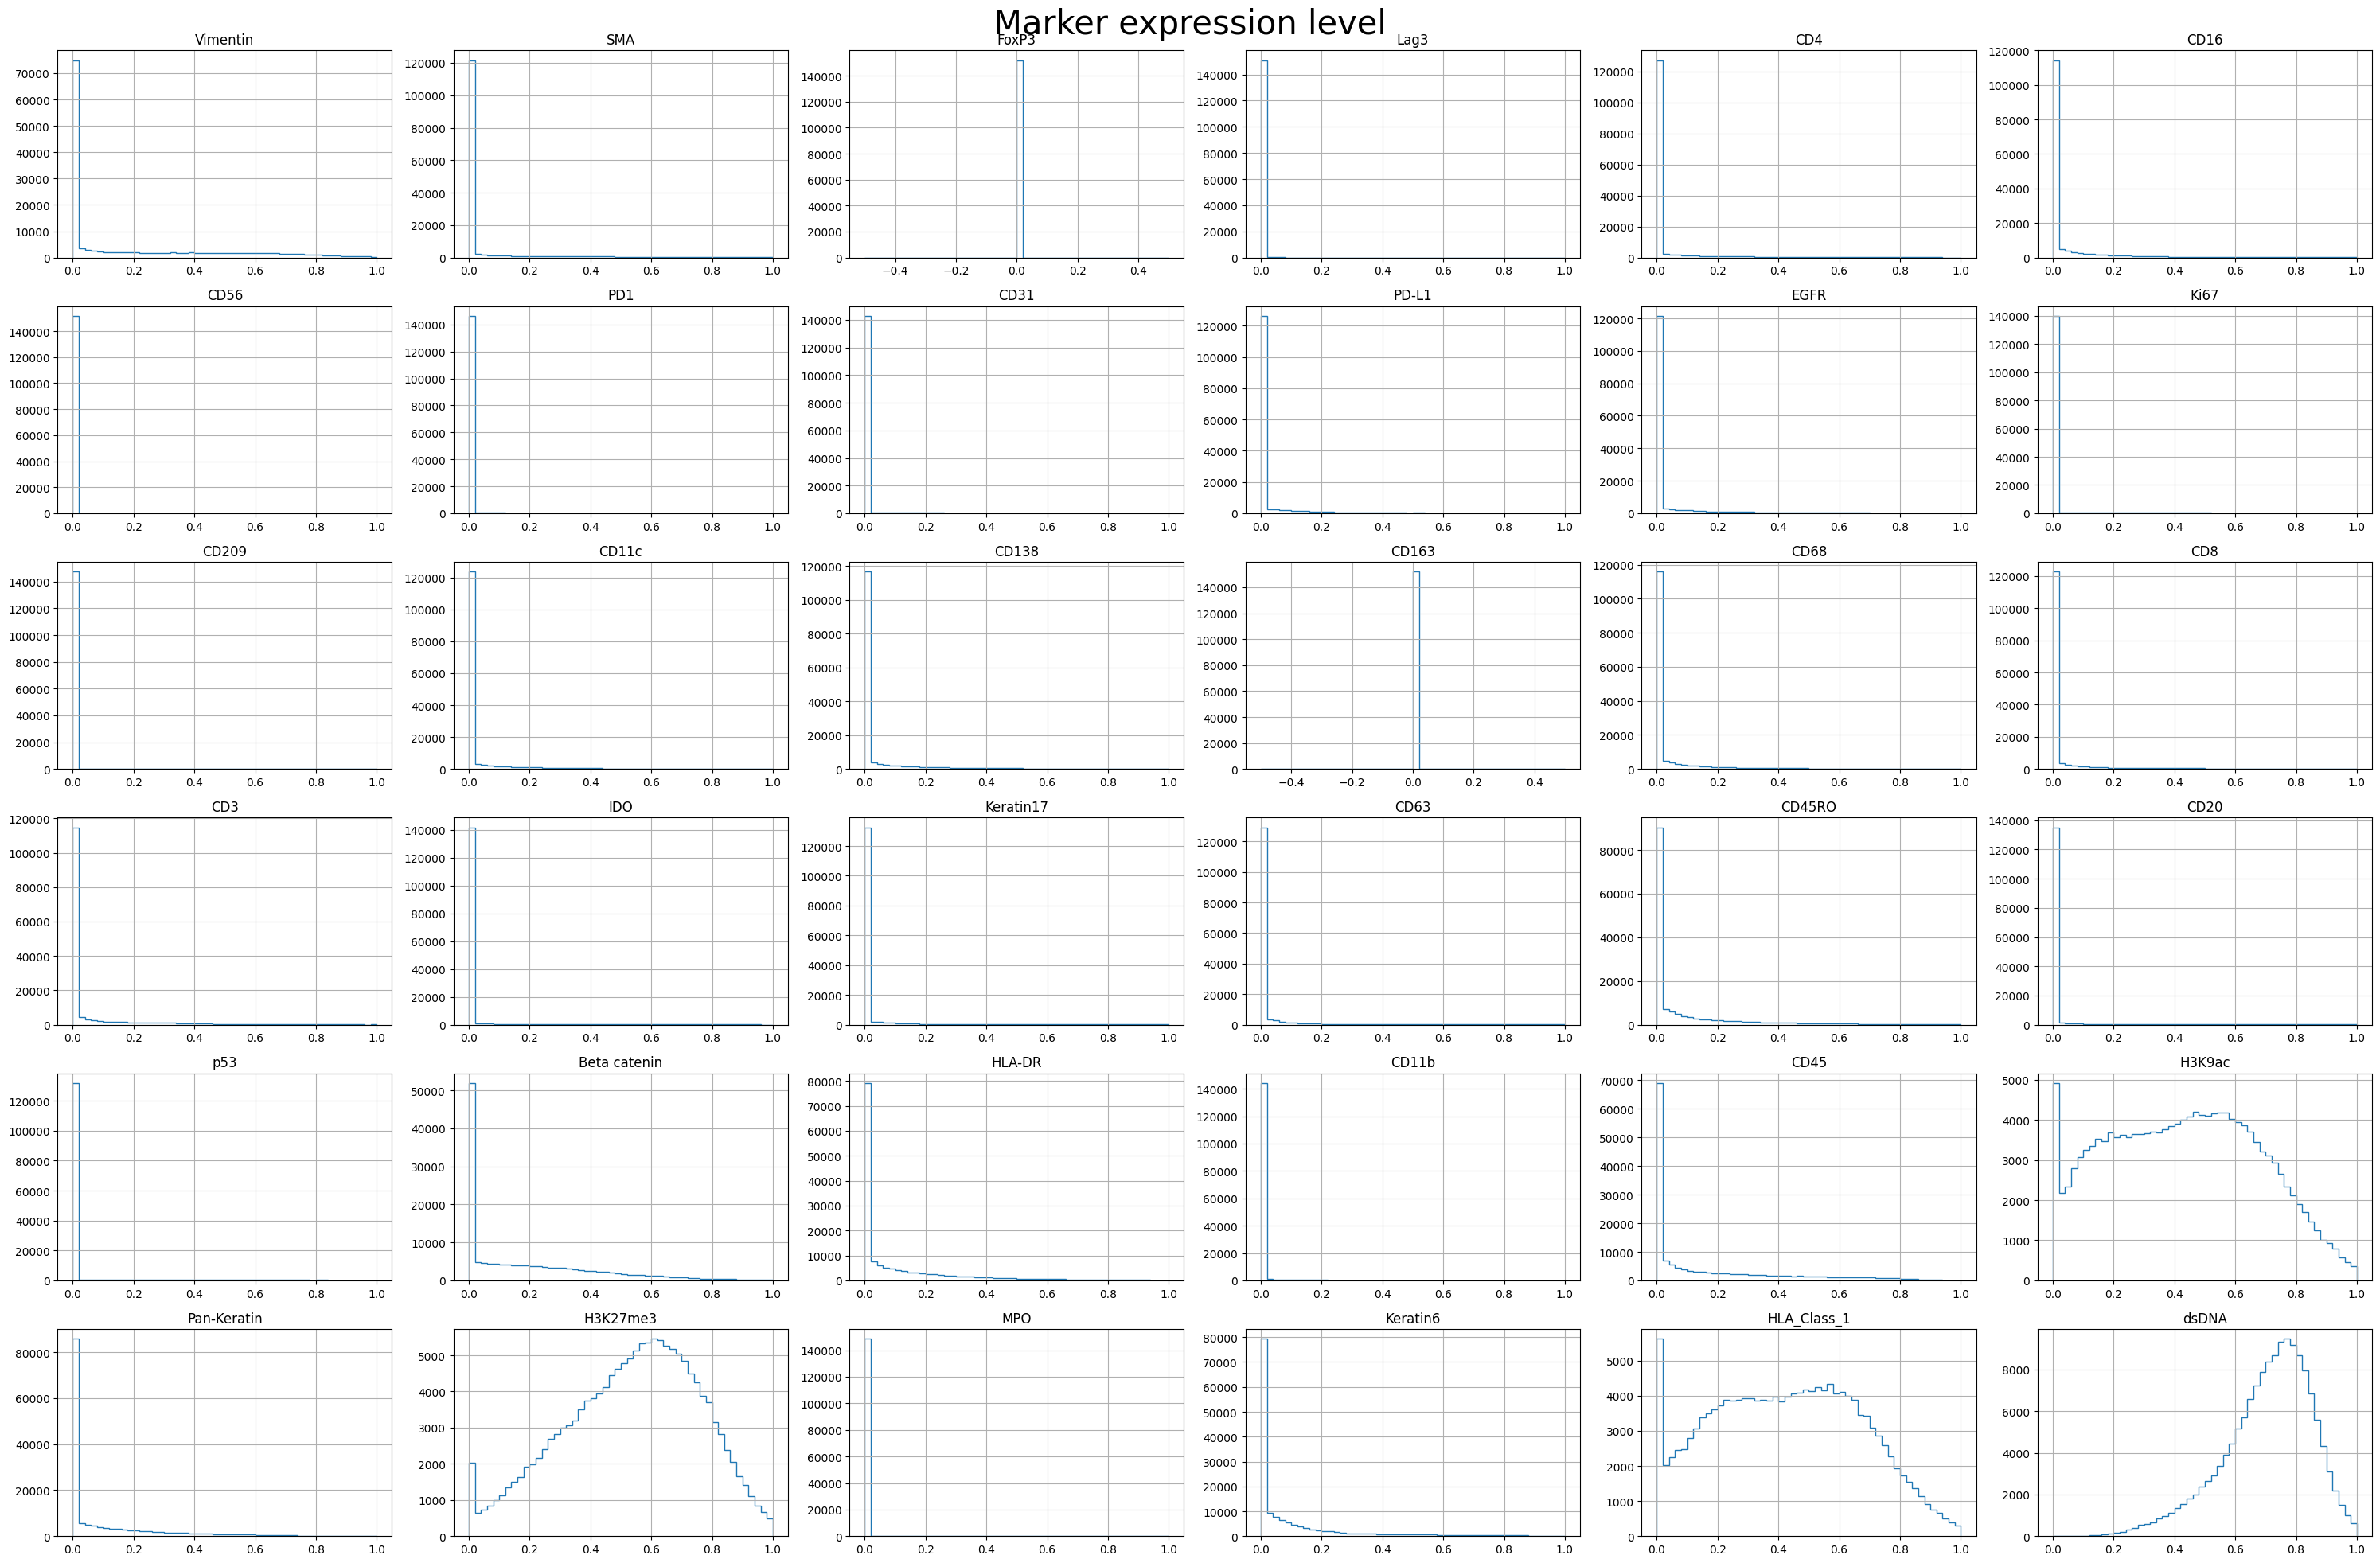

In [53]:
marker_expression(sample_data_scale[cols], markers=None, save=False, fname=None, dpi='figure', log=False)

## Marker quality check

In [18]:
sample_data = pd.read_csv("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\CyTOF_TNBC\\input_data\\TNBC_Data.csv")
sample_data_qc = sample_data.drop(["SampleID", "cellLabelInImage","cellSize",
                                   "C","Na","Si","P","Ca", "Fe", "dsDNA", 
                                   "Background", "Ta", "Au", "tumorYN", 
                                   "B7H3", "OX40", "CSF-1R",
                                   "tumorCluster", "Group", "immuneCluster", 
                                   "immuneGroup","DetailedGroup", "upperGroup"], axis=1)

c:\Users\Public\Farkkila_lab_datasets\Tribus\tribus\tribus\visualization.py:211: RuntimeWarning: divide by zero encountered in log
  plt.stairs(np.log(hist)+sys.float_info.epsilon, edges, label="{}".format(uc))


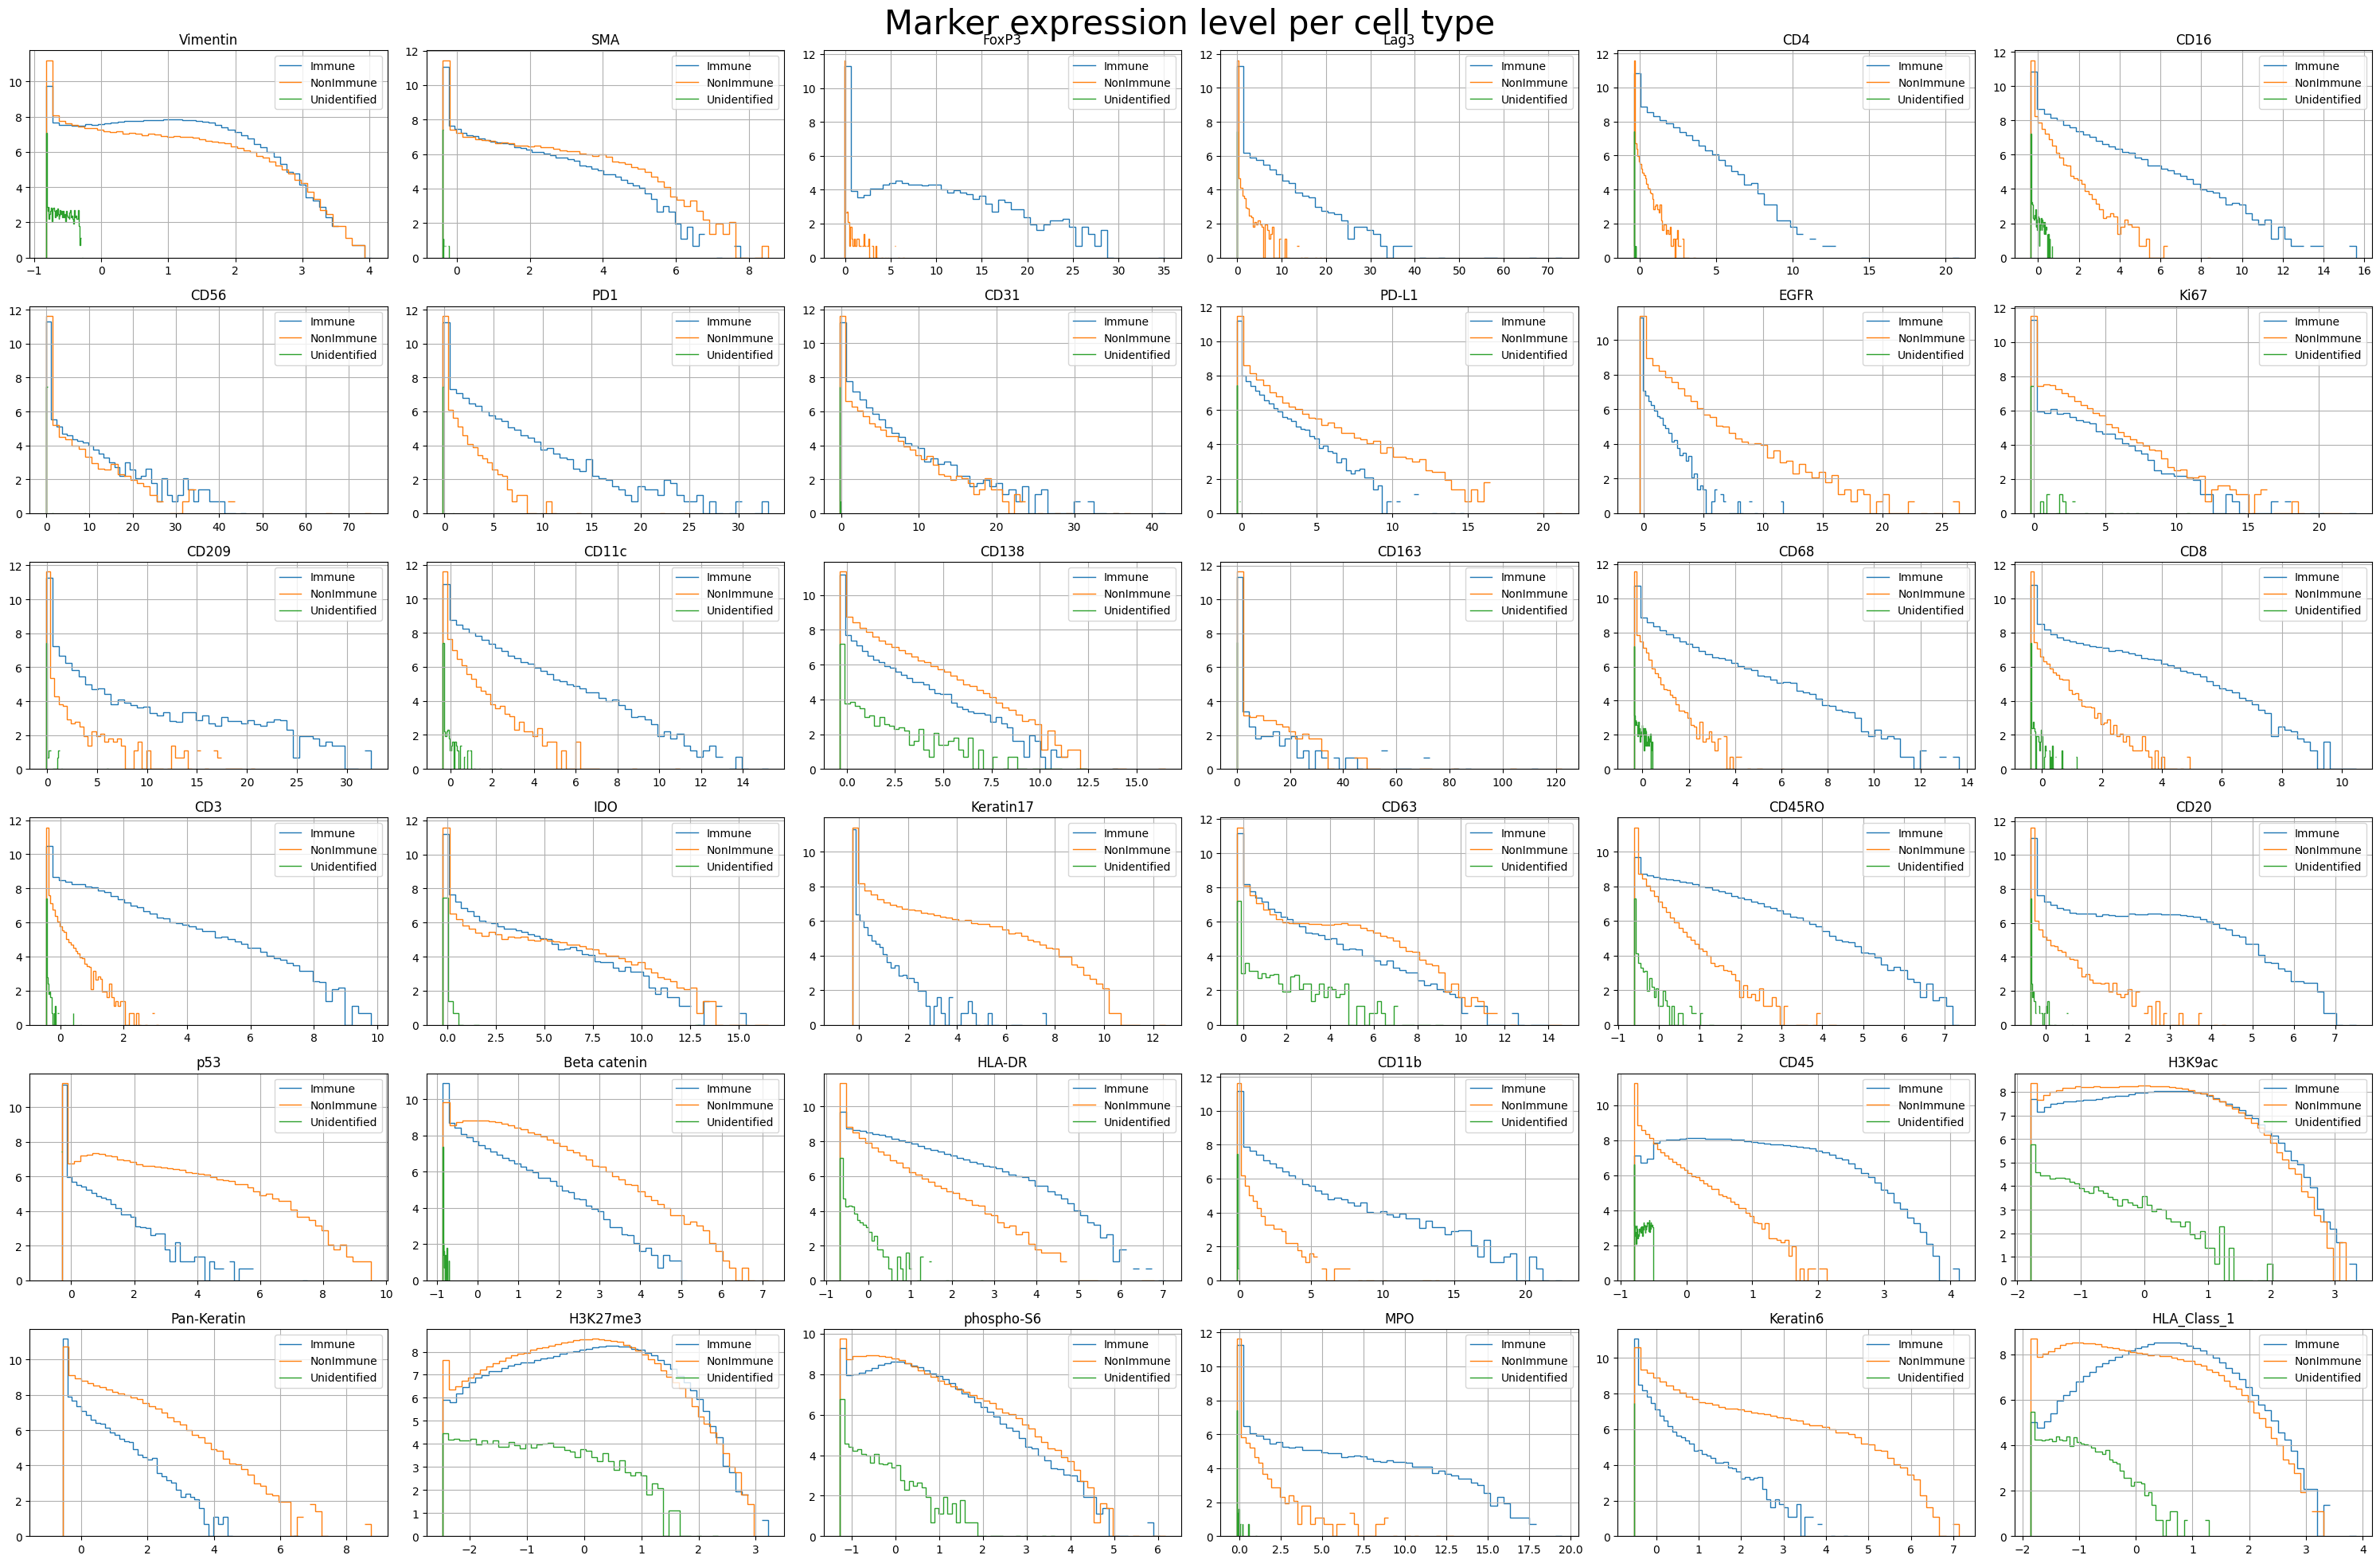

In [12]:
label = {'Global': sample_data['upperGroup']}
label = pd.DataFrame(label)

marker_expression_by_cell_type(sample_data_qc, label, cell_types=None, markers=None, level="Global", save=False, fname=None, dpi='figure', log=True)

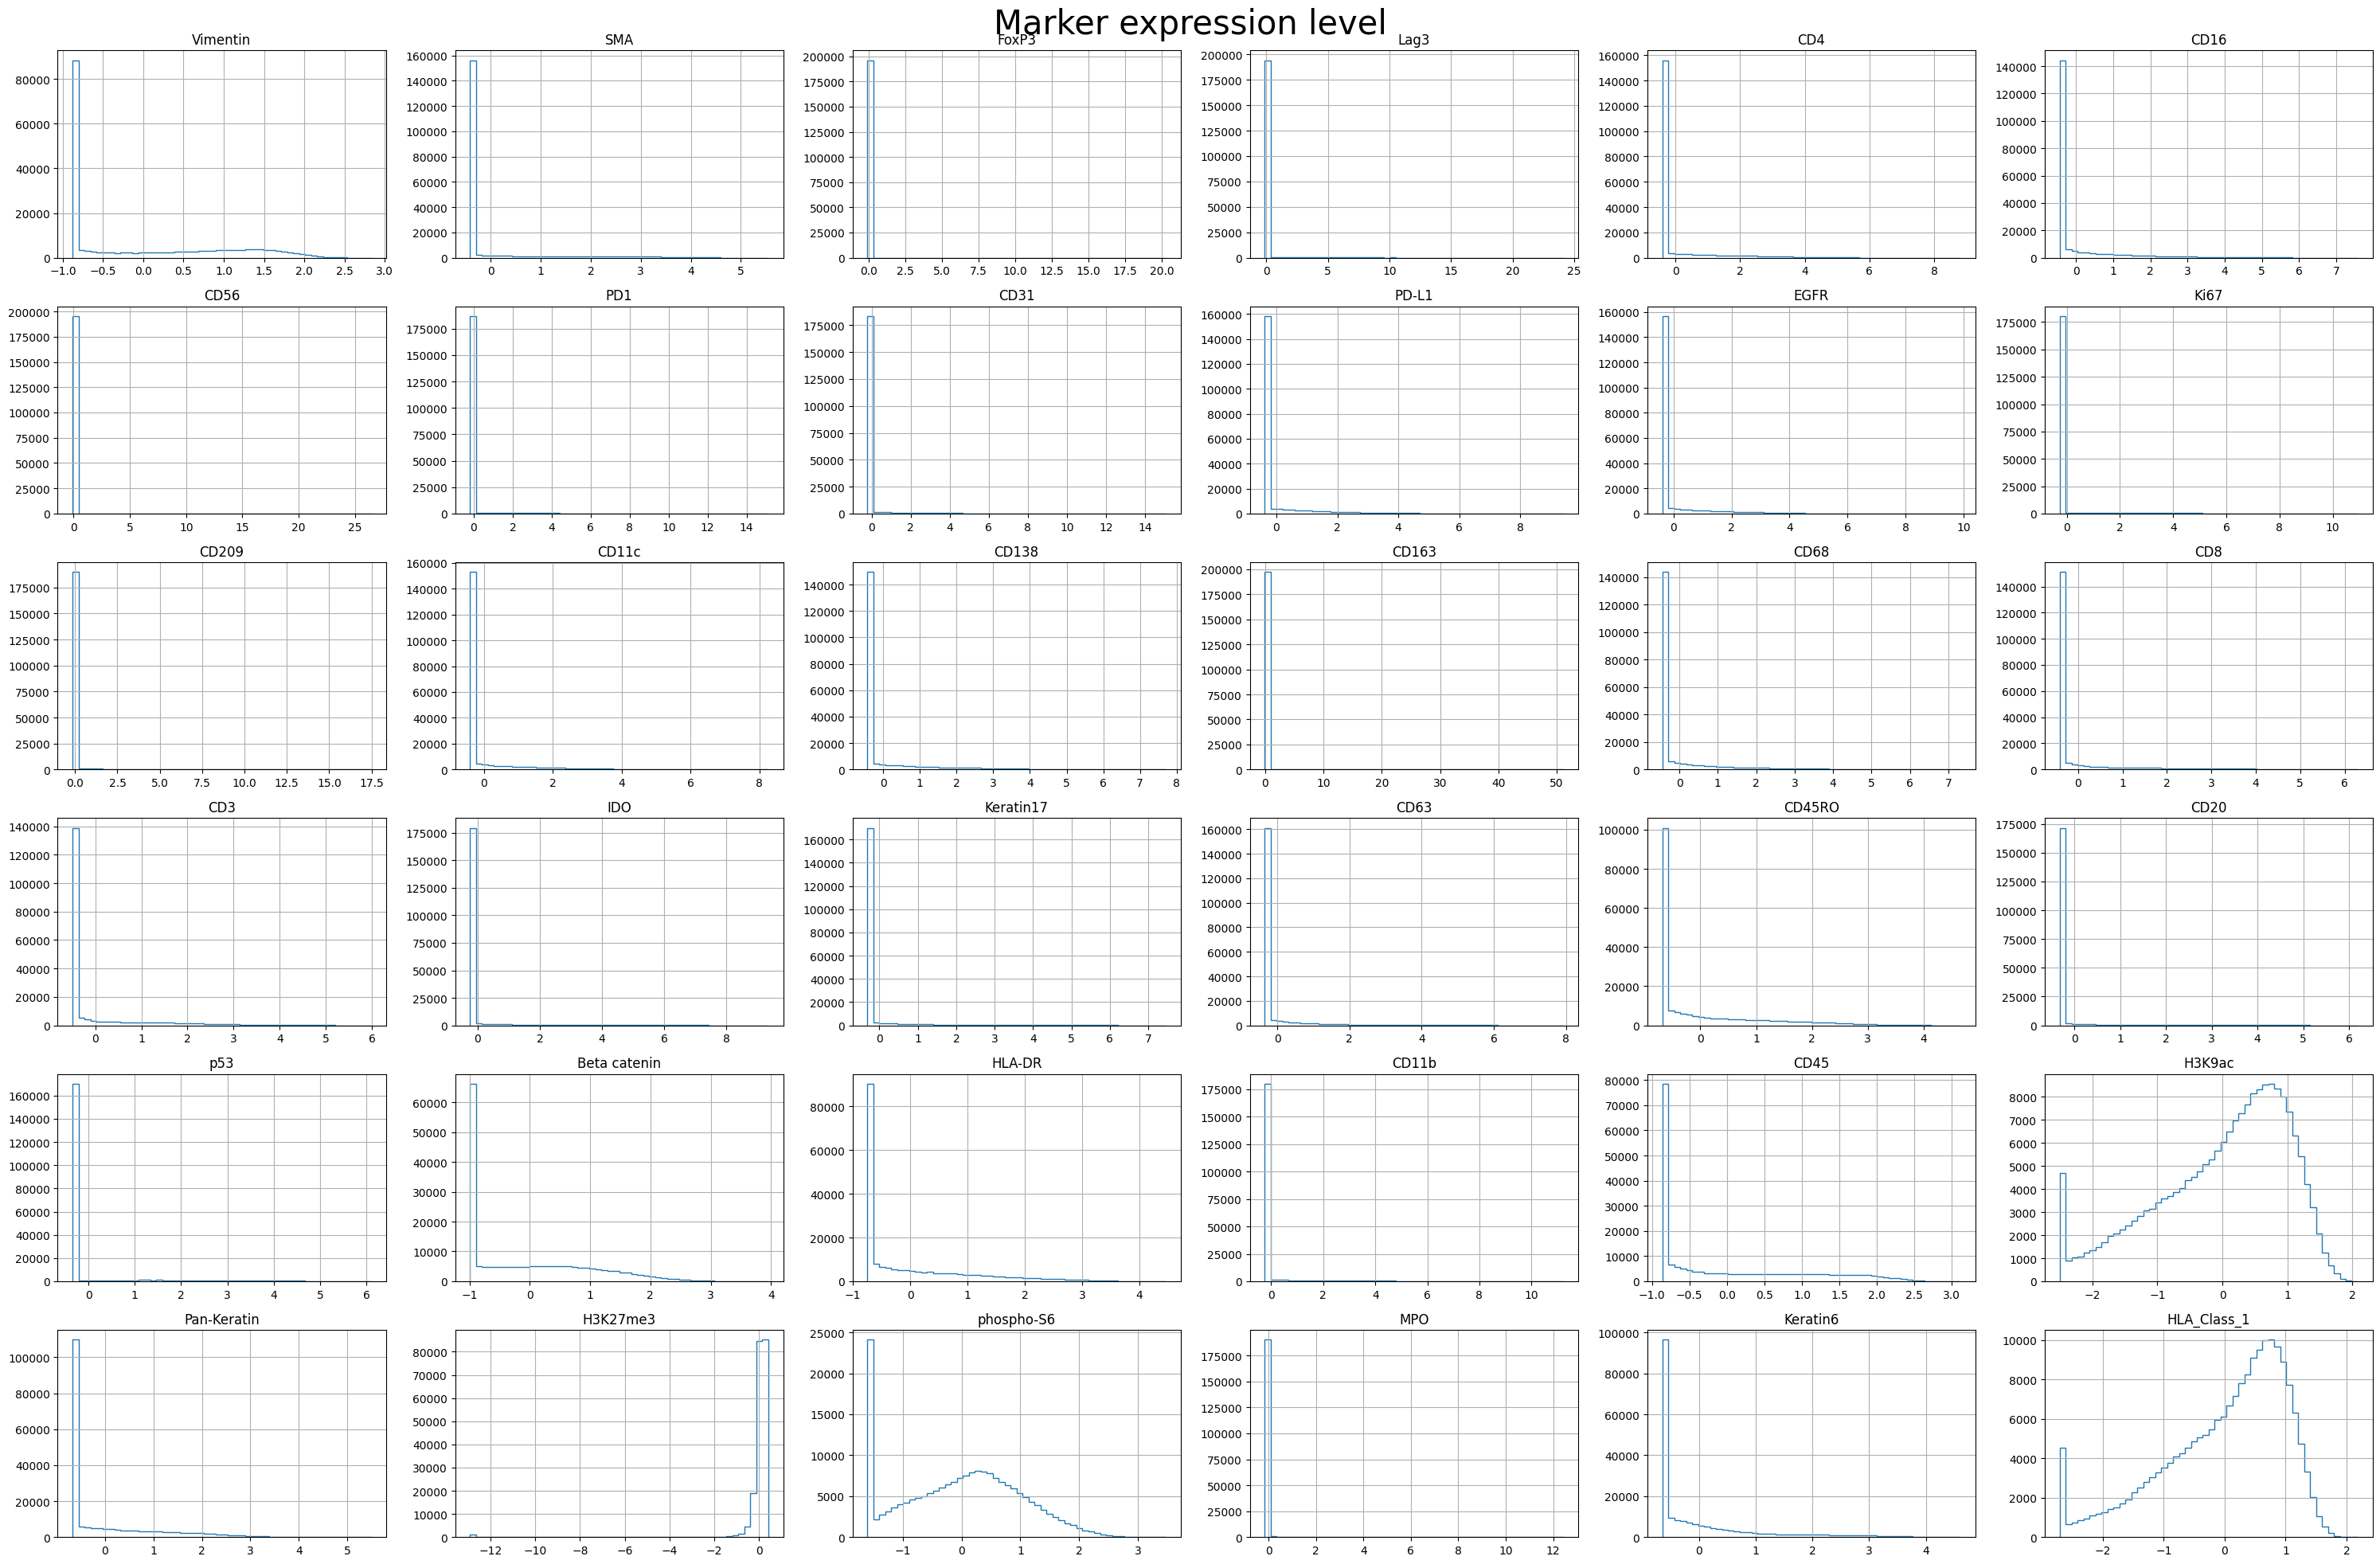

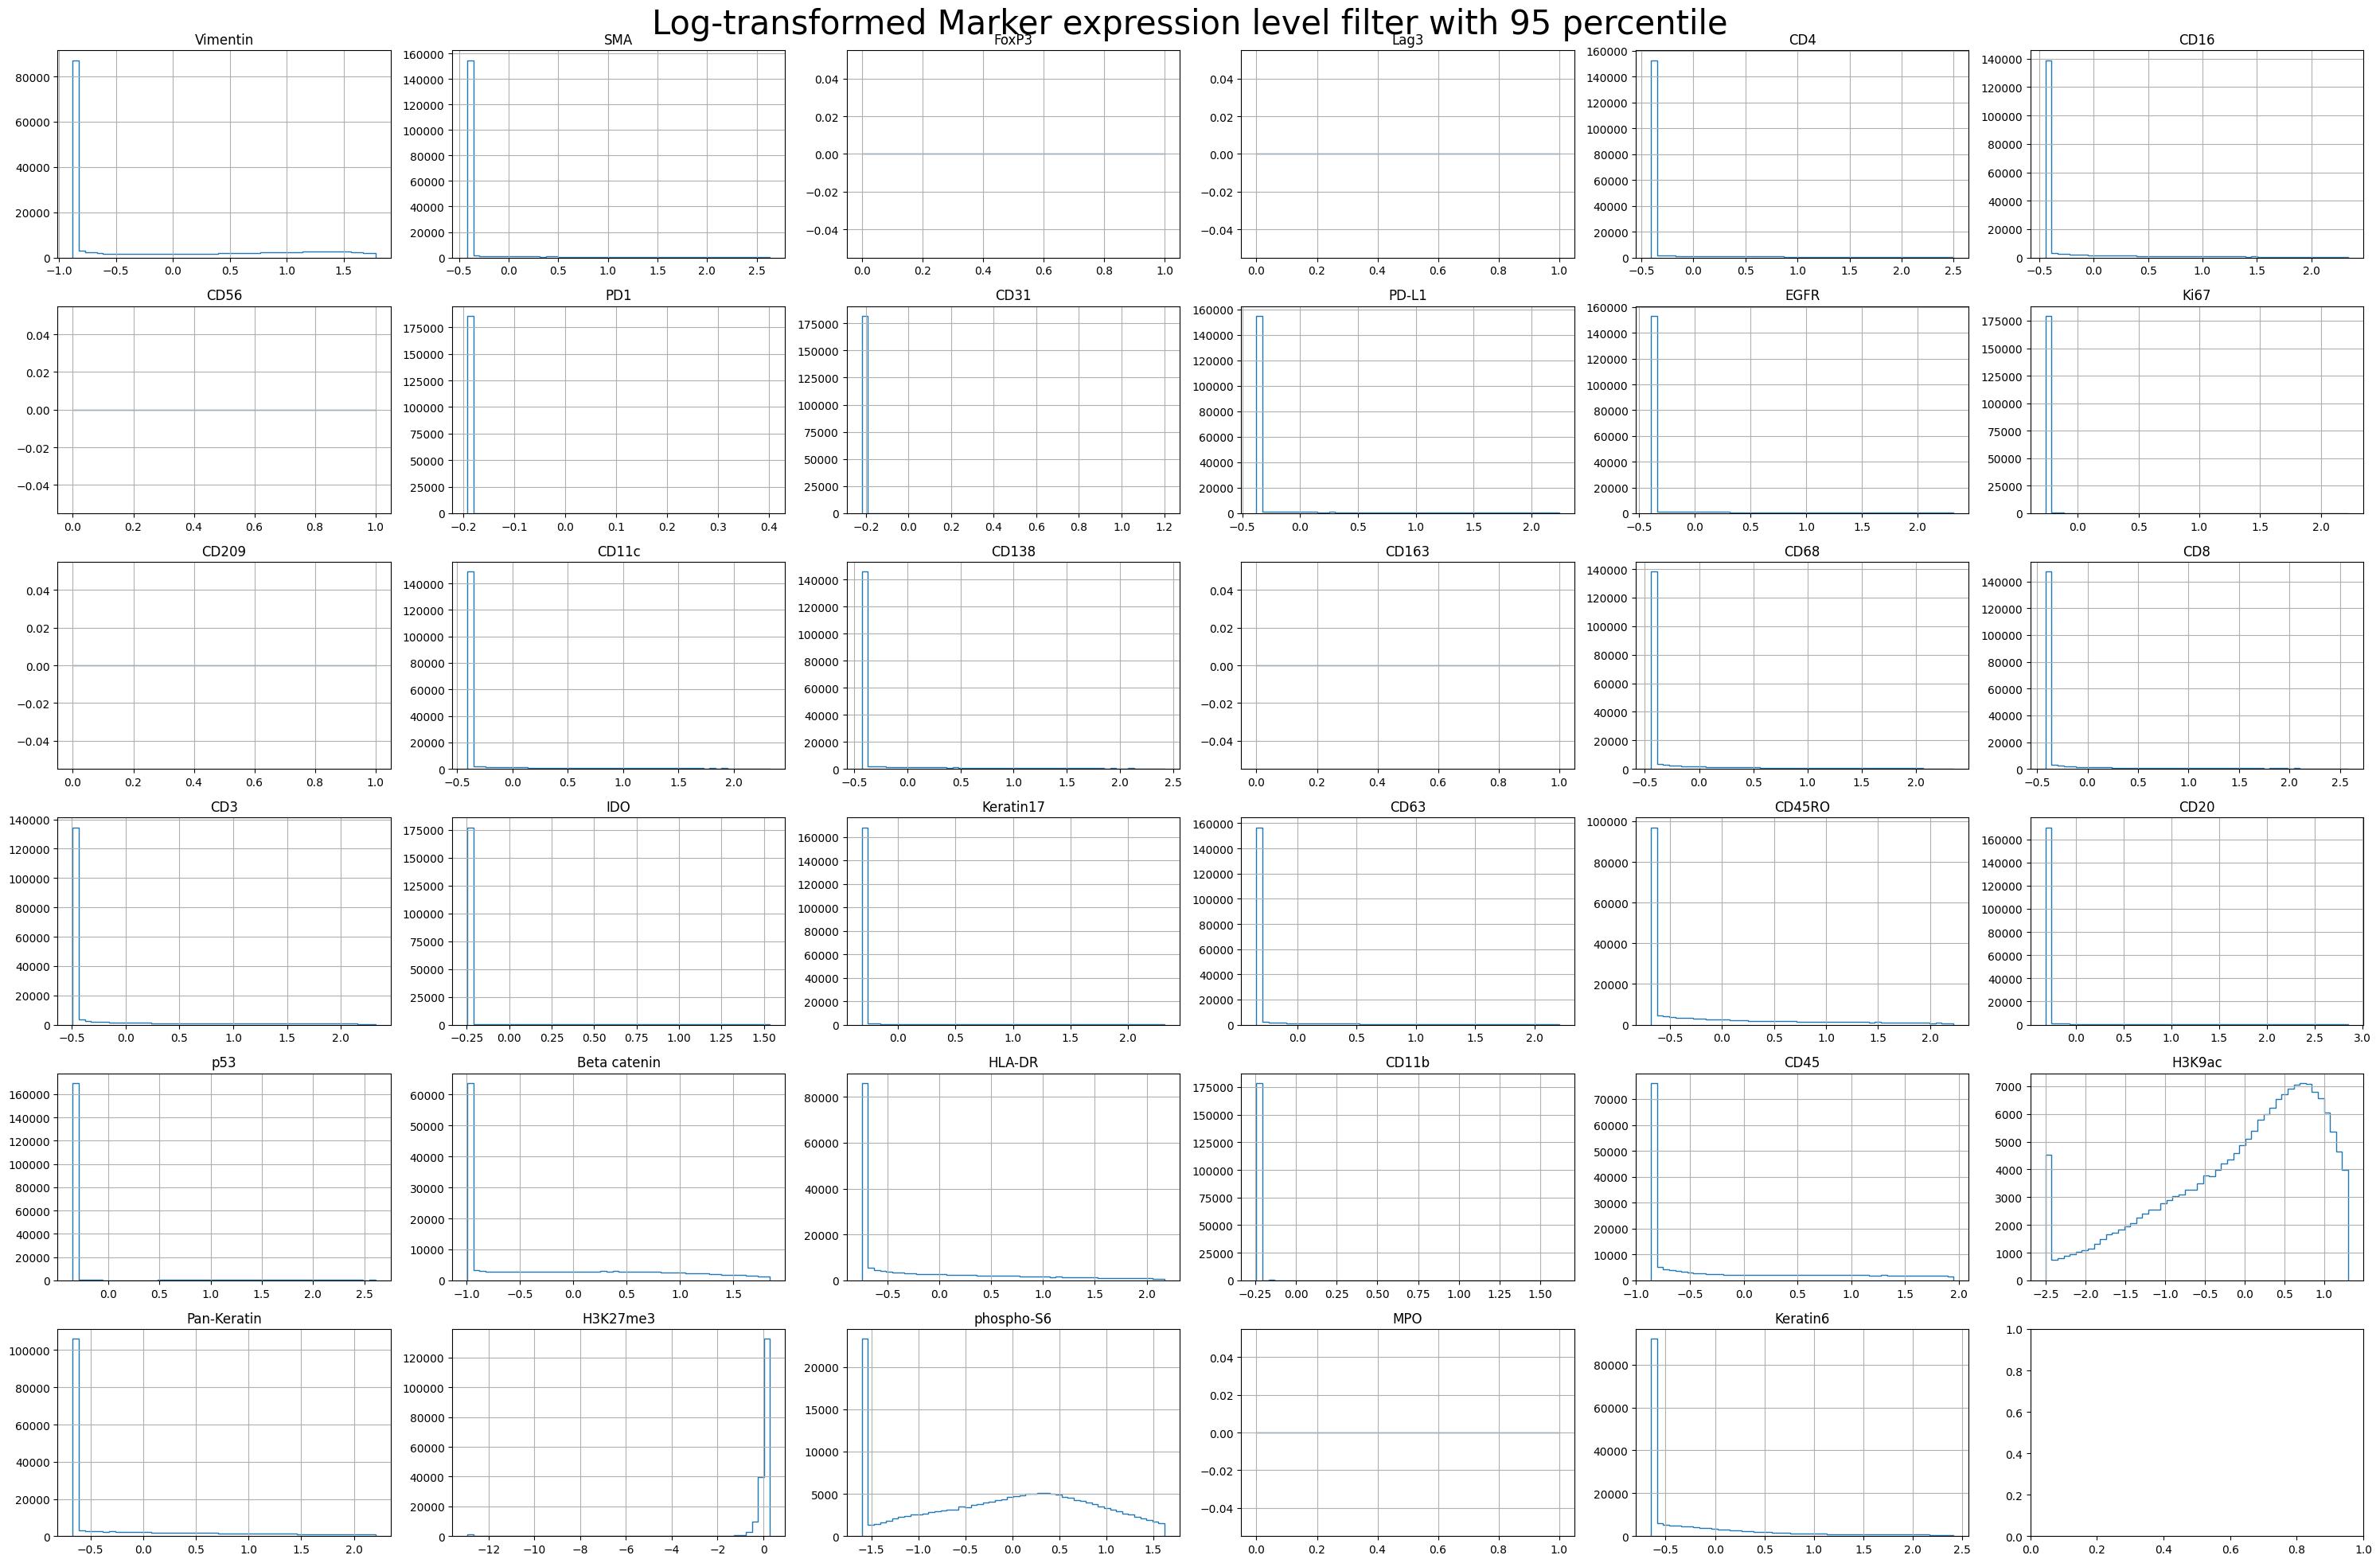

In [26]:
sample_data_log = z_score(np.log(sample_data_qc + abs(np.min(sample_data_qc)) + sys.float_info.epsilon))
marker_expression(sample_data_log, markers=None, save=False, fname=None, dpi='figure', log=False)

markers = sample_data_log.columns.values
fig, axs = plt.subplots(math.ceil(len(markers) / 6), 6, figsize=(30, 20))
fig.suptitle("Log-transformed Marker expression level filter with 95 percentile", fontsize=30)
for i in range(len(markers)-1): 
    ax = axs[i//6, i%6]
    plt.sca(ax)
    hist, edges = np.histogram(sample_data_log[markers[i]][sample_data_log[markers[i]] < np.percentile(sample_data_log[markers[i]],95)], 
                               bins=50)
    plt.stairs(hist, edges, label="{}".format(markers[i]))
    plt.title(f"{markers[i]}")
    plt.grid()
    plt.tight_layout()
plt.show()

<Axes: >

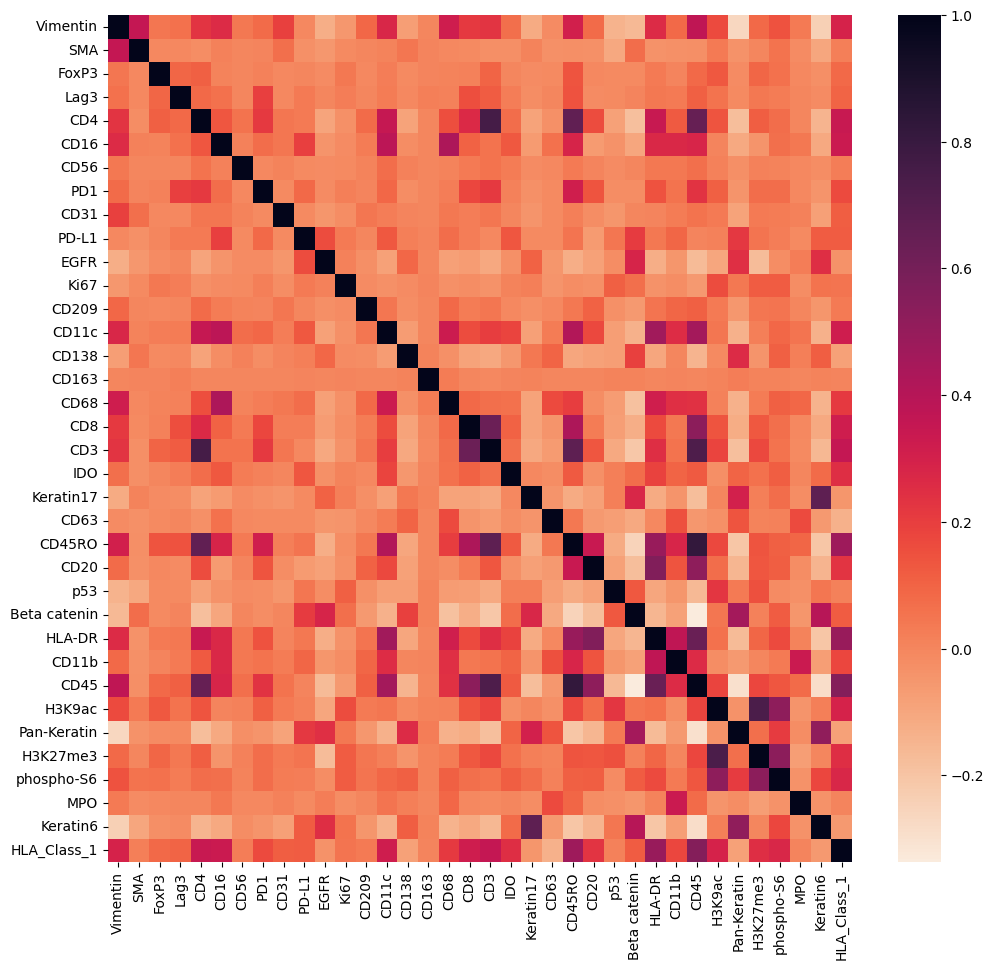

In [3]:
plt.figure(figsize=(12, 11))
sns.heatmap(sample_data_qc.corr(),cmap=sns.cm.rocket_r)

<Axes: >

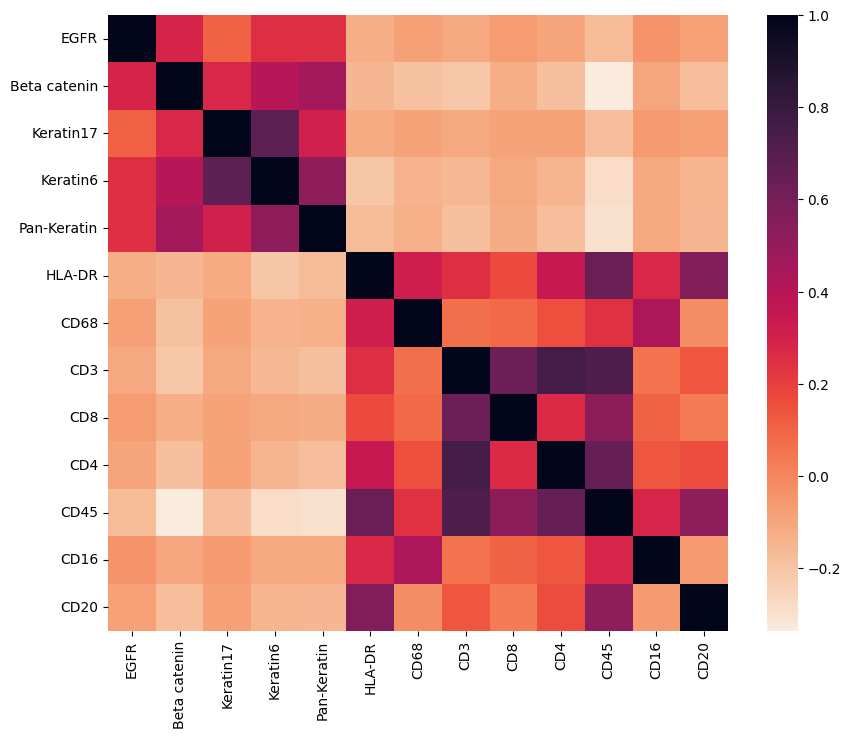

In [4]:
# check the marker correlation matrix we choose for the clustering method
df = pd.ExcelFile("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\CyTOF_TNBC\\logic_gate.xlsx")
logic = pd.read_excel(df, df.sheet_names, index_col=0)
marker_df = sample_data[logic["Global"]["Immune"].index]
plt.figure(figsize=(10,8))
sns.heatmap(marker_df.corr(),cmap=sns.cm.rocket_r)

## Run Tribus on TNBC

In [2]:
# read input files
sample_data = pd.read_csv("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\CyTOF_TNBC\\input_data\\TNBC_Data.csv")
df = pd.ExcelFile("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\CyTOF_TNBC\\logic_gate.xlsx")
logic = pd.read_excel(df, df.sheet_names, index_col=0)
sample_data

SampleID  cellLabelInImage  cellSize  C       Na        Si        P   
0              1                 2       146  0 -0.59061  0.875220 -2.57650  \
1              1                 3       102  0 -0.49870  0.017464 -1.22490   
2              1                 4        43  0 -1.48730 -0.630440 -1.91070   
3              1                 5       211  0 -1.00530 -0.532270 -1.74300   
4              1                 6       177  0  0.15803 -0.710290  0.51737   
...          ...               ...       ... ..      ...       ...      ...   
197673        41              5093        90  0 -0.31842  0.332450 -1.60410   
197674        41              5094       132  0  0.30404  1.467600 -2.16650   
197675        41              5095       123  0 -0.39525 -0.146200 -1.89770   
197676        41              5096        99  0 -0.75282  0.494750 -1.52110   
197677        41              5097        66  0 -0.98901  0.545940 -1.43800   

              Ca       Fe     dsDNA  ...  HLA_Class_1        Ta       Au   
0      -0.806060 -0.23440 -1.308000  ...    -0.537380  2.481100  2.32660  \
1      -0.501520 -1.34120  0.522570  ...    -0.620600  2.304300  2.18710   
2      -1.228000 -1.39370 -1.782200  ...    -1.750500  1.393300  1.47820   
3      -0.944850 -1.09960 -0.057906  ...    -0.524450  1.886800  1.58620   
4      -0.096251 -1.05260  0.355020  ...    -0.997730 -0.510270 -0.49627   
...          ...      ...       ...  ...          ...       ...      ...   
197673  0.444140  0.62615 -2.625700  ...     1.174900 -0.002699  0.33340   
197674  0.597130  0.35472 -2.835300  ...     0.549420  2.425100  2.35800   
197675  0.192400  0.43584 -2.706900  ...    -0.004921  1.966500  1.84560   
197676  0.458440  0.38360 -1.911500  ...     0.024687  1.371600  1.61960   
197677  0.608050  0.10373 -1.158900  ...     0.418960  0.823490  0.77602   

        tumorYN  tumorCluster                   Group  immuneCluster   
0             1             0  Keratin-positive tumor              0  \
1             0             0                  Immune             46   
2             1             0  Keratin-positive tumor              0   
3             1             0  Keratin-positive tumor              0   
4             0             0                  Immune             75   
...         ...           ...                     ...            ...   
197673        1             0  Keratin-positive tumor              0   
197674        1            21                   Tumor              0   
197675        0             0                  Immune             31   
197676        0             0                  Immune             56   
197677        0             0                  Immune             65   

        immuneGroup           DetailedGroup  upperGroup  
0                 0  Keratin-positive tumor   NonImmune  
1                 4                   CD3 T      Immune  
2                 0  Keratin-positive tumor   NonImmune  
3                 0  Keratin-positive tumor   NonImmune  
4                 6                       B      Immune  
...             ...                     ...         ...  
197673            0  Keratin-positive tumor   NonImmune  
197674            0                   Tumor   NonImmune  
197675            8             Macrophages      Immune  
197676           12            Other immune      Immune  
197677            6                       B      Immune  

[197678 rows x 59 columns]

In [3]:
# Run Tribus on z-scored dataset
labels, scores = run_tribus(sample_data, logic, depth=2, normalization=z_score) # modify depth

Global, subsetting done
Immune, subsetting done
NonImmune, subsetting done
10.325196667512257 minutes


In [4]:
labels.head(10)

Global Immune         NonImmune       final_label
0  NonImmune    NaN  Mesenchymal-like  Mesenchymal-like
1  NonImmune    NaN  Mesenchymal-like  Mesenchymal-like
2  NonImmune    NaN  Mesenchymal-like  Mesenchymal-like
3  NonImmune    NaN  Mesenchymal-like  Mesenchymal-like
4  NonImmune    NaN  Mesenchymal-like  Mesenchymal-like
5  NonImmune    NaN  Mesenchymal-like  Mesenchymal-like
6  NonImmune    NaN  Mesenchymal-like  Mesenchymal-like
7  NonImmune    NaN  Mesenchymal-like  Mesenchymal-like
8  NonImmune    NaN  Mesenchymal-like  Mesenchymal-like
9  NonImmune    NaN  Mesenchymal-like  Mesenchymal-like

## Clustering quality check

<BarContainer object of 3 artists>

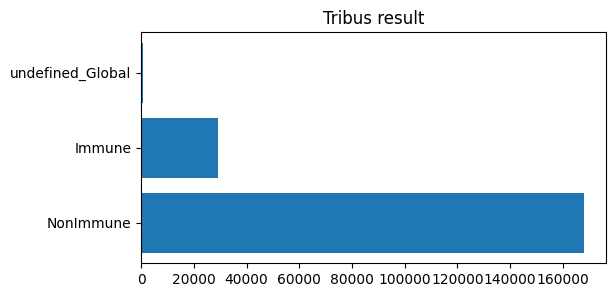

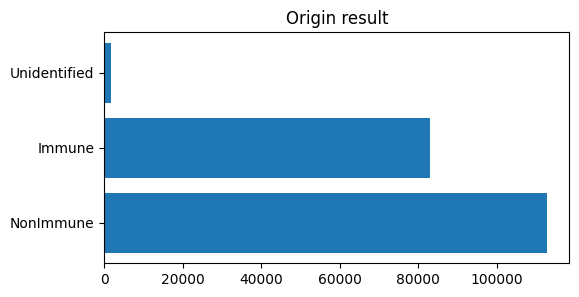

In [15]:
label_stat = labels["Global"].value_counts().rename_axis('final_label').reset_index(name='count')
name = label_stat['final_label']
num = label_stat['count']
fig, ax = plt.subplots(figsize =(6, 3))
plt.title('Tribus result')
ax.barh(name, num)

label_stat = pd.DataFrame({'Group': sample_data['upperGroup']})["Group"].value_counts().rename_axis('Group').reset_index(name='count')
name = label_stat['Group']
num = label_stat['count']
fig, ax = plt.subplots(figsize =(6, 3))
plt.title('Origin result')
ax.barh(name, num)

<BarContainer object of 17 artists>

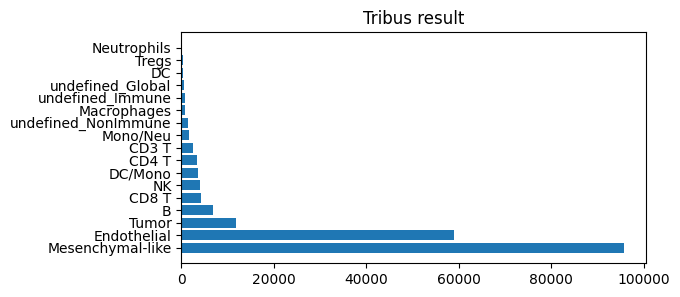

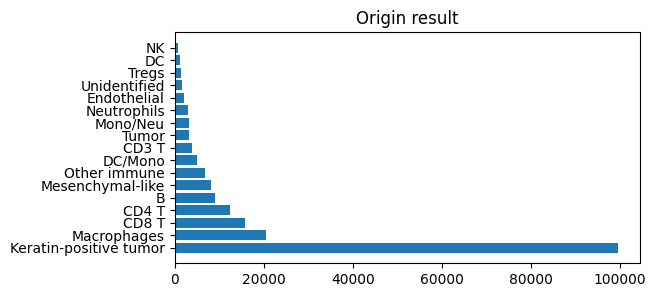

In [9]:
# Barplot, show the number of cells in each type
label_stat = labels["final_label"].value_counts().rename_axis('final_label').reset_index(name='count')
name = label_stat['final_label']
num = label_stat['count']
fig, ax = plt.subplots(figsize =(6, 3))
plt.title('Tribus result')
ax.barh(name, num)

label_stat = pd.DataFrame({'Group': sample_data['DetailedGroup']})["Group"].value_counts().rename_axis('Group').reset_index(name='count')
name = label_stat['Group']
num = label_stat['count']
fig, ax = plt.subplots(figsize =(6, 3))
plt.title('Origin result')
ax.barh(name, num)

                Immune  NonImmune
EGFR         -0.277531   0.073228
Beta catenin -0.596609   0.123965
Keratin17    -0.265136   0.051805
Keratin6     -0.428012   0.110946
Pan-Keratin  -0.495697   0.039043
HLA-DR        1.284428  -0.281227
CD68          0.565387  -0.108474
CD3           1.448063  -0.293507
CD8           1.095890  -0.200681
CD4           1.408108  -0.290903
CD45          1.677618  -0.373859
CD16          0.688080  -0.091632
CD20          0.906373  -0.275547


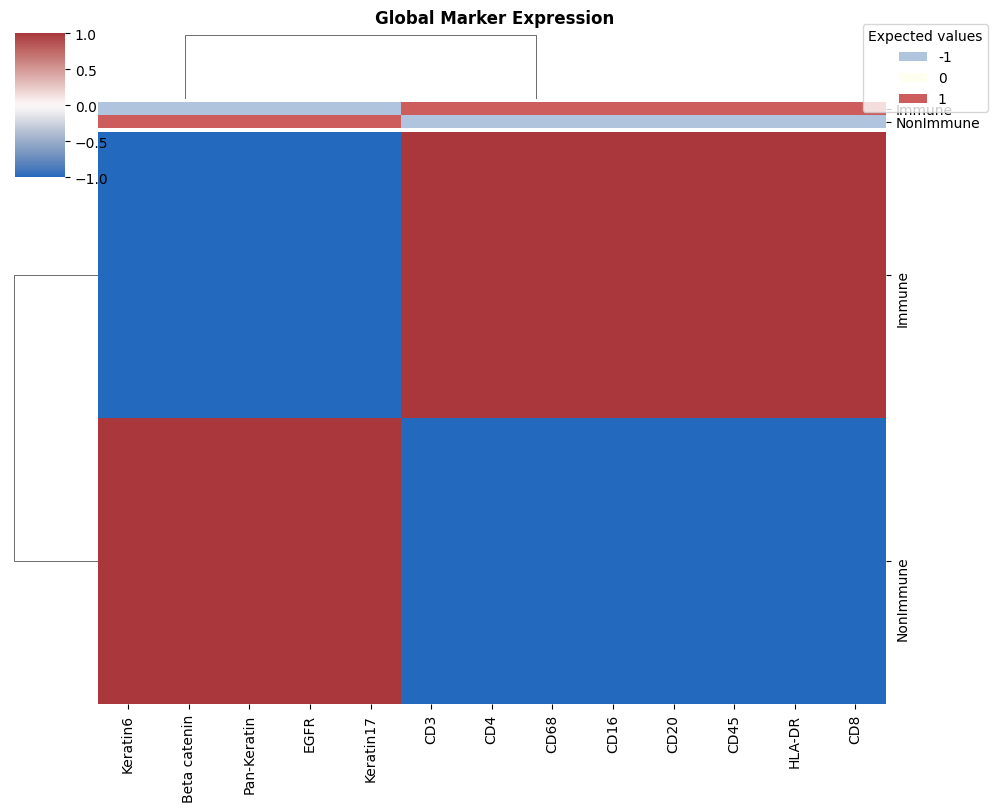

EGFR  Beta catenin  Keratin17  Keratin6  Pan-Keratin  HLA-DR  CD68   
Immune     -1.0          -1.0       -1.0      -1.0         -1.0     1.0   1.0  \
NonImmune   1.0           1.0        1.0       1.0          1.0    -1.0  -1.0   

           CD3  CD8  CD4  CD45  CD16  CD20  
Immune     1.0  1.0  1.0   1.0   1.0   1.0  
NonImmune -1.0 -1.0 -1.0  -1.0  -1.0  -1.0

In [10]:
# Marker Expression heatmap (use median value)
from matplotlib.patches import Patch

def get_subsets(sample_file, labels):
    cell_types = np.unique(labels)
    new_file = sample_file.copy()
    new_file.loc[:, 'labels'] = labels
    subsets = []
    normal_cell_types = []
    for cell_type in cell_types:
        if "undefined" in cell_type or "other" in cell_type:
            continue
        else:
            subsets.append(new_file.loc[new_file['labels'] == cell_type])
            normal_cell_types.append(cell_type)
    return subsets, normal_cell_types

def heatmap_for_mean_expression(sample_file, labels, logic, level="Global", save=False, fname=None,
                                  dpi='figure', transform=z_score, title="",
                                  c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                  cmap_='vlag', dendrogram_ratio_=0.1):
    df_mean = pd.DataFrame()
    df_annotation_table = pd.DataFrame()
    markers = list(logic[level].index)
    filtered_sample = sample_file[markers]
    filtered_sample = filtered_sample[labels[level].notnull()]
    filtered_labels = labels[level][labels[level].notnull()]
    description_table = logic[level]
    values = [-1, 0, 1]
    tables, cell_types = get_subsets(filtered_sample, filtered_labels)

    for i in range(len(cell_types)):
        df_mean[cell_types[i]] = tables[i].iloc[:, :-1].mean()
        new_value = description_table[cell_types[i]]
        palette_ = c_palette
        lut = dict(zip(values, palette_))
        row_colors = new_value.map(lut)
        df_annotation_table[cell_types[i]] = list(row_colors)

    df_annotation_table = df_annotation_table.set_index(df_mean.index)
    print(df_mean)
    df_mean = transform(df_mean.transpose())
    sns.clustermap(df_mean, figsize=(10, 8), cmap=cmap_, col_colors=df_annotation_table,
                   dendrogram_ratio=dendrogram_ratio_, colors_ratio=0.02).fig.suptitle(title, fontweight="bold", y=1.01)
    handles = [Patch(facecolor=lut[name]) for name in lut]
    plt.legend(handles, lut, title='Expected values', bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure,
               loc='upper right')

    if save:
        plt.savefig(fname, dpi=dpi)
    else:
        plt.show()
    return df_mean

heatmap_for_mean_expression(sample_data, labels, logic, level="Global", save=False, fname=None,
                                  dpi='figure', transform=z_score, title="Global Marker Expression",
                                  c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                  cmap_='vlag', dendrogram_ratio_=0.1)

C:\Users\Localadmin_kangzigi\AppData\Local\Temp\ipykernel_19444\3353489688.py:18: RuntimeWarning: invalid value encountered in true_divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Text(158.08159722222223, 0.5, 'True')

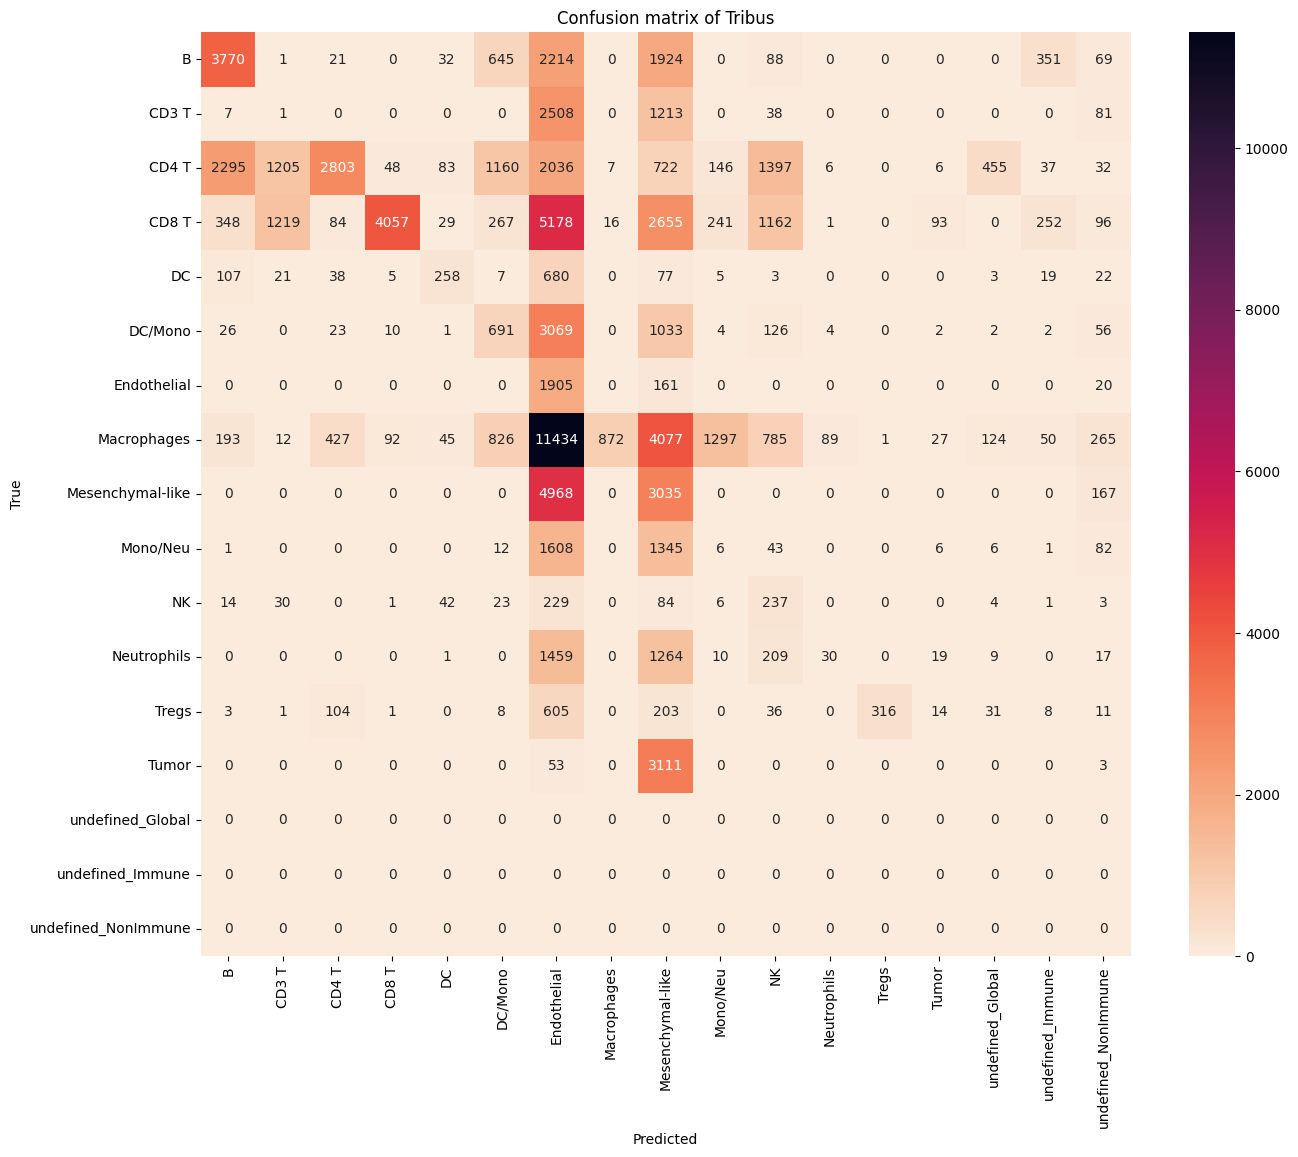

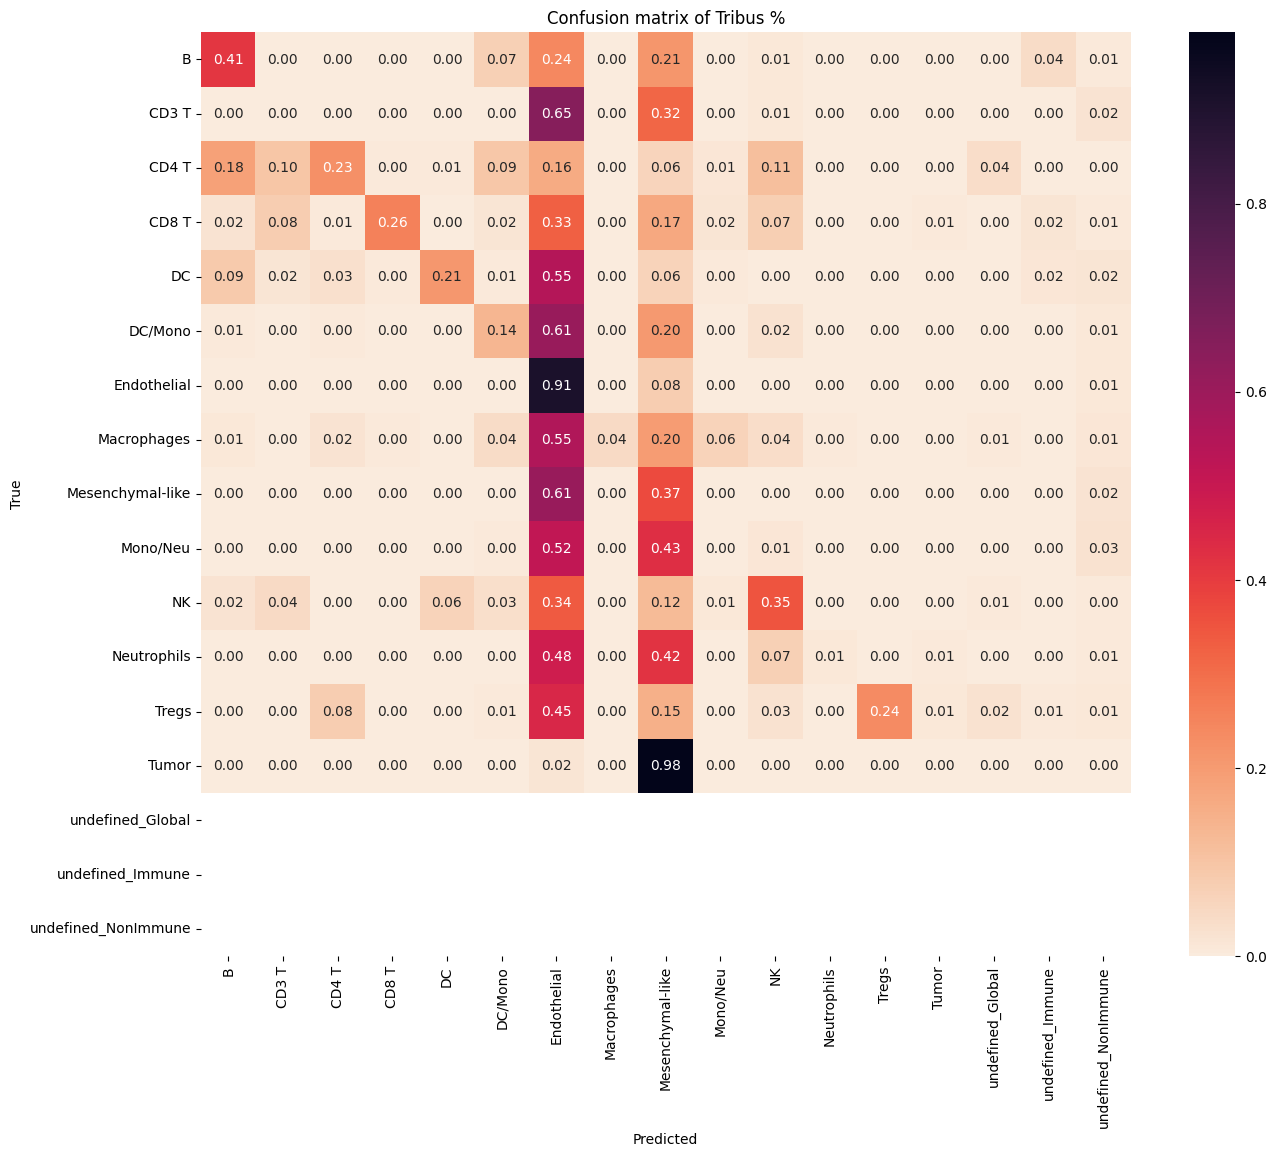

In [13]:
# confusion matrix
celltype_true = np.array(sample_data["DetailedGroup"]).tolist()
celltype_pred = np.array(labels["final_label"]).tolist()
cm_labels = np.unique(labels["final_label"])
cm = confusion_matrix(celltype_true, 
                      celltype_pred, 
                      labels = cm_labels)
                                                       
df_cm = pd.DataFrame(cm, index = cm_labels,
                  columns = cm_labels)
plt.figure(figsize = (15,12))
sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
plt.title('Confusion matrix of Tribus')
plt.xlabel('Predicted')
plt.ylabel('True')


cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cmn = pd.DataFrame(cmn, index = cm_labels,
                  columns = cm_labels)
plt.figure(figsize = (15,12))
sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
plt.title('Confusion matrix of Tribus %')
plt.xlabel('Predicted')
plt.ylabel('True')

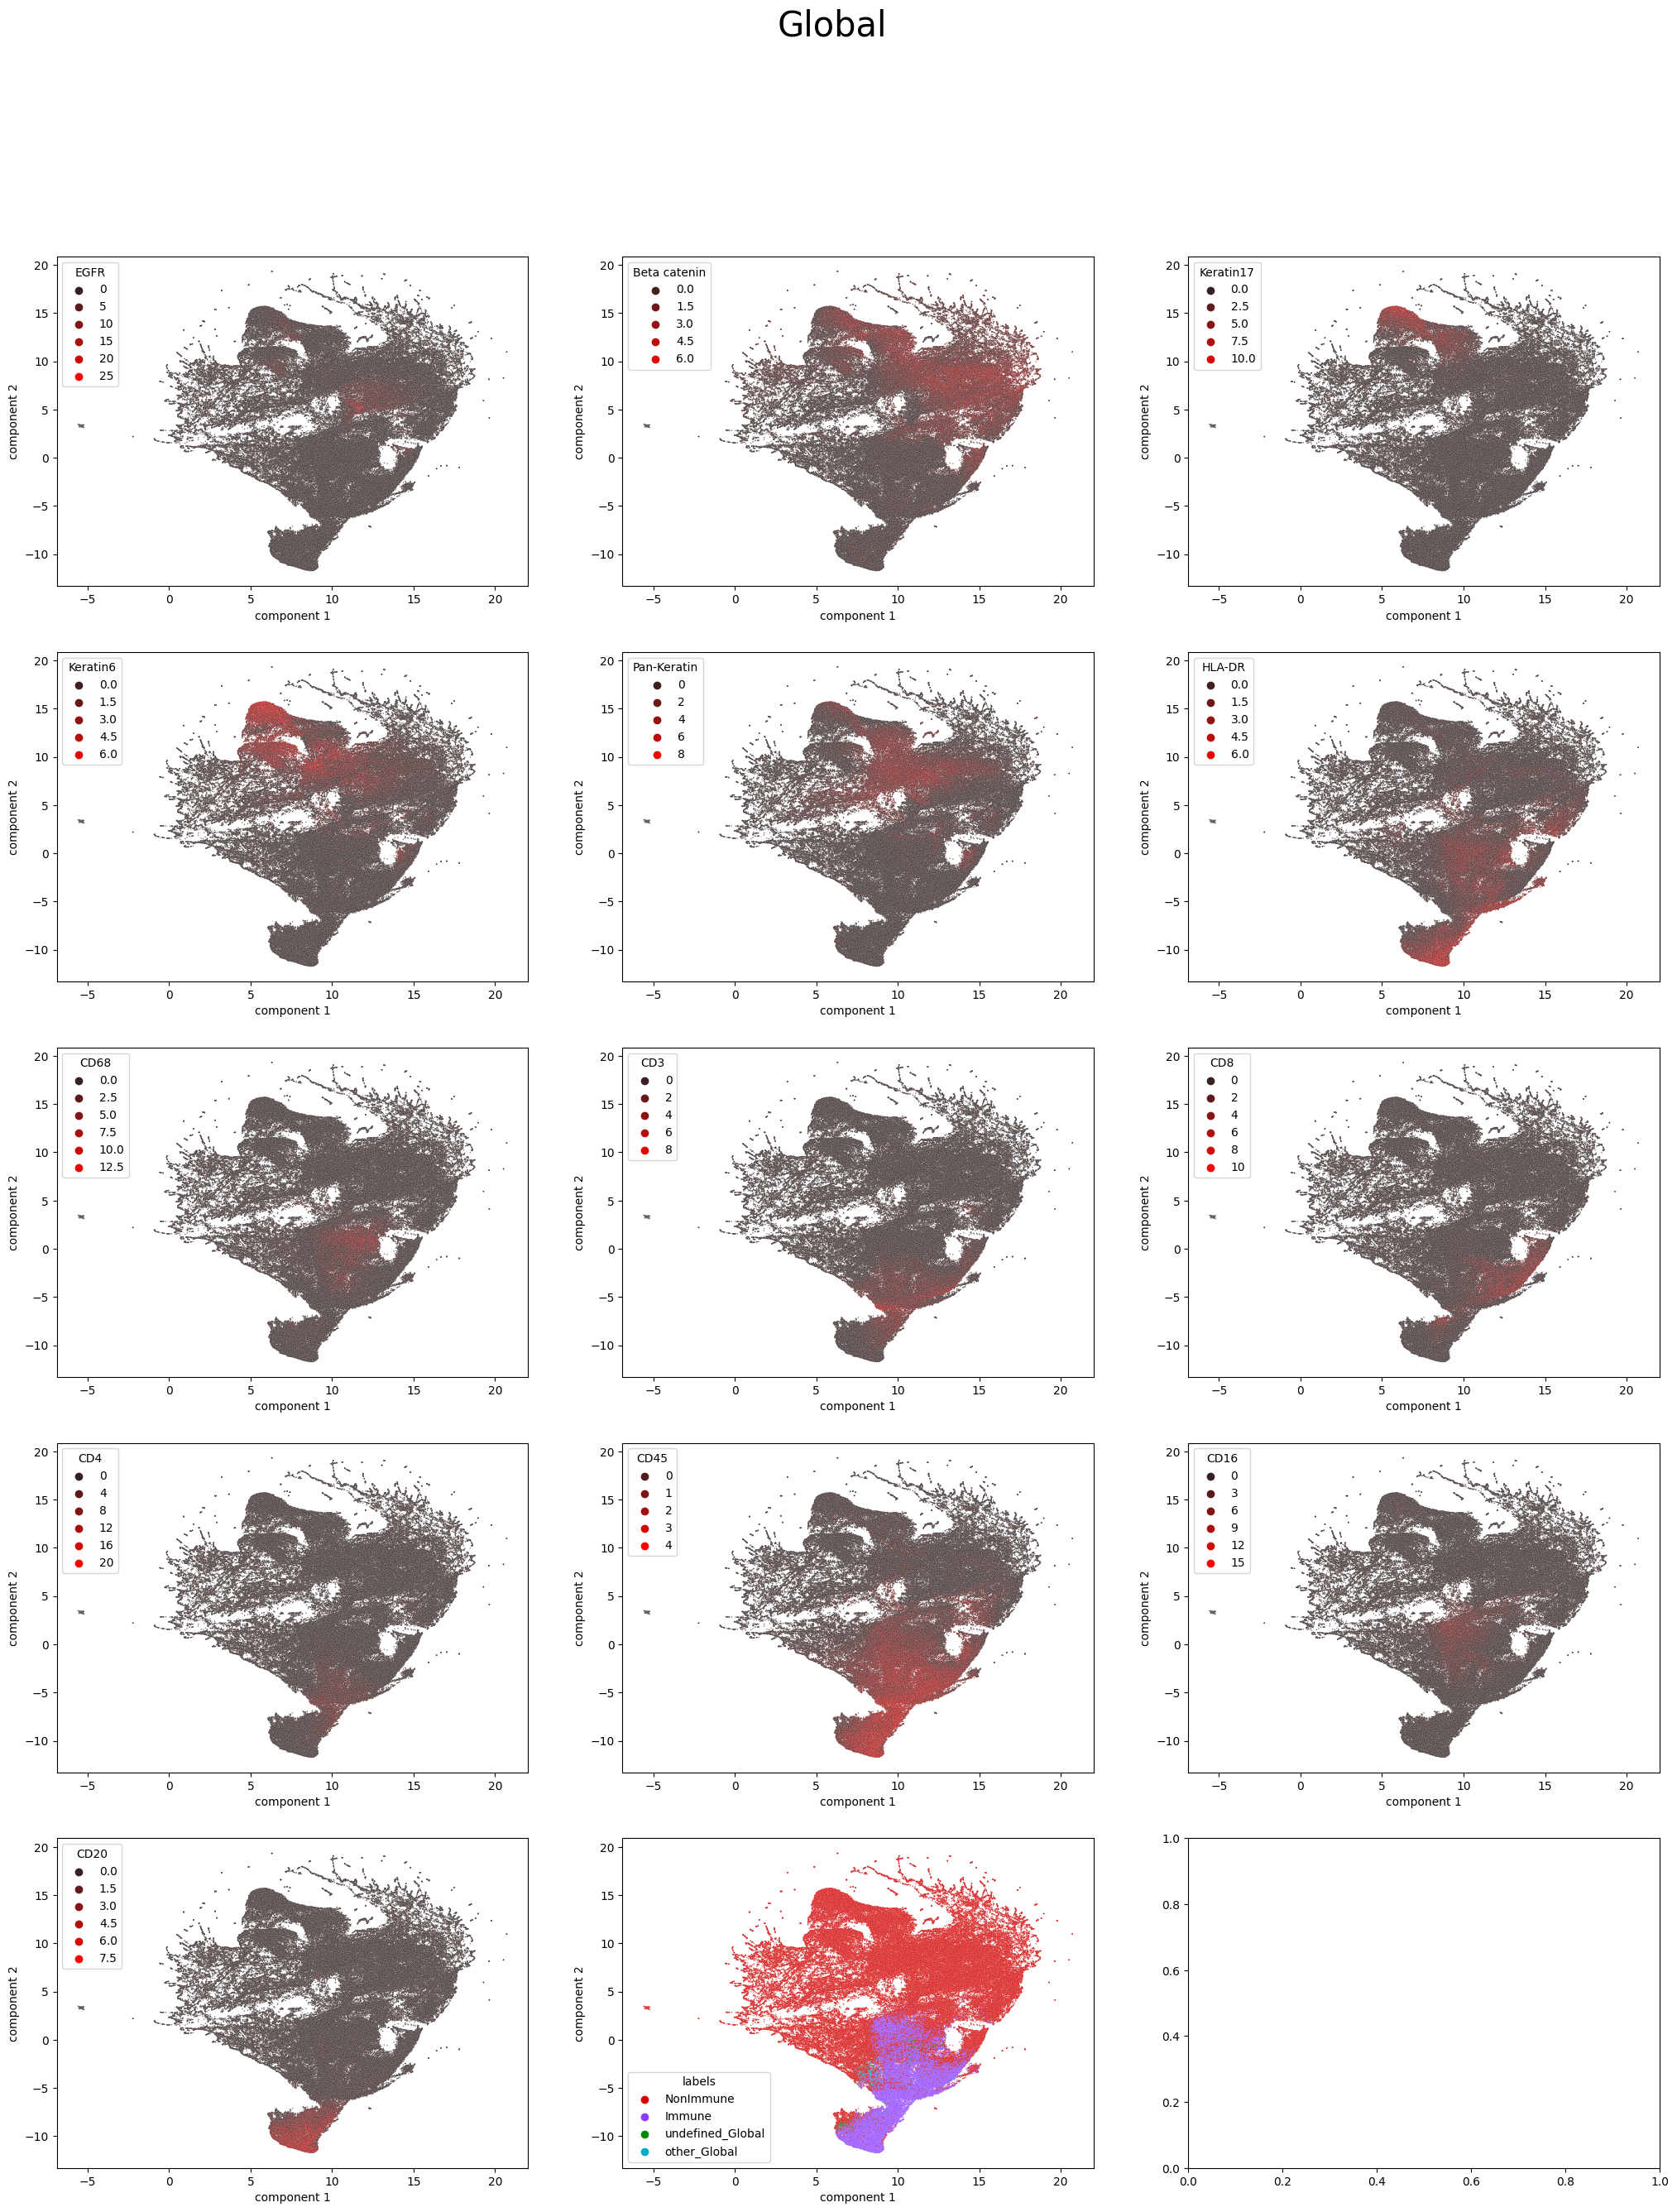

In [8]:
# scale the dataset into (0,1) before UMAP
#scaler = MinMaxScaler() 
#arr_scaled = scaler.fit_transform(sample_data)
#sample_data_scaled = pd.DataFrame(arr_scaled, columns=sample_data.columns,index=sample_data.index)

umap_vis(sample_data, labels, markers=logic["Global"].index.values.tolist(), save=False, fname=None,  level="Global", title=None, init='spectral',
             random_state=0, n_neighbors=10, min_dist=0.1, metric='correlation', palette_markers='mycolormap',
             palette_cell='tab10', dpi='figure')